## Imports and settings

In [17]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys
import json
from pprint import pprint
import collections

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import rc
plt.rcParams["font.family"] = "sans-serif"
import numpy as np
import ipywidgets as widgets
from matplotlib import gridspec
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
# from tqdm import tqdm

project_root = '..'
sys.path.append(project_root)

from sleeprnn.data.loader import load_dataset
from sleeprnn.helpers.reader import RefactorUnpickler
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.detection import metrics
from sleeprnn.detection.postprocessor import PostProcessor
from sleeprnn.common import constants, pkeys

SEED_LIST = [123, 234, 345, 456]
RESULTS_PATH = os.path.join(project_root, 'results')
COMPARISON_PATH = os.path.join(project_root, 'resources', 'comparison_data')
DPI = 200
CUSTOM_COLOR = {'red': '#c62828', 'grey': '#455a64', 'blue': '#0277bd', 'green': '#43a047'} 

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Load database and predicted probabilities

In [2]:
optimal_thr_for_ckpt_dict = {
    os.path.join('20190504_bsf_wn_train_mass_ss', 'bsf'): [0.64, 0.52, 0.52, 0.48],
    os.path.join('20190504_bsf_wn_train_mass_kc', 'bsf'): [0.52, 0.56, 0.54, 0.56],
    os.path.join('20190506_bsf_n2_train_mass_ss', 'bsf'): [0.52, 0.46, 0.50, 0.50],
    os.path.join('20190506_bsf_n2_train_mass_kc', 'bsf'): [0.52, 0.52, 0.56, 0.46],
    os.path.join('20190516_bsf_n2_train_inta_ss', 'bsf'): [0.48, 0.52, 0.48, 0.44],
    os.path.join('20190516_bsf_v2_n2_train_inta_ss', 'bsf'): [0.46, 0.52, 0.50, 0.46],
    os.path.join('20190522_bsf_newer_wins_fix_n2_train_inta_ss', 'bsf'): [0.44, 0.5, 0.44, 0.42],
    os.path.join('20190522_bsf_e1_n2_train_mass_ss', 'bsf'): [0.44, 0.56, 0.48, 0.48],
    os.path.join('20190522_bsf_e2_n2_train_mass_ss', 'bsf'): [0.6, 0.44, 0.36, 0.56],
    os.path.join('20190525_bsf_ch3_n2_train_inta_ss', 'bsf'): [0.48, 0.56, 0.52, 0.5],
    os.path.join('20190525_bsf_v4_n2_train_mass_ss', 'bsf_1'): [0.46, 0.4, 0.5, 0.46],
    os.path.join('20190527_bsf_v7_k3_n2_train_mass_ss', 'bsf_2'): [0.52, 0.44, 0.48, 0.42],
    os.path.join('20190530_bsf_v10_n2_train_mass_ss', 'bsf'): [0.6, 0.44, 0.56, 0.42],
    os.path.join('20190601_bsf_v11_n2_train_mass_ss', 'filters_32_64_128'): [0.64, 0.36, 0.58, 0.4],
    os.path.join('20190601_bsf_v11_n2_train_mass_ss', 'filters_64_128_256'): [0.62, 0.6, 0.52, 0.44],
    os.path.join('20190603_grid_cwt_fb05_n2_train_mass_ss', 'v12_f_32_64'): [0.66, 0.46, 0.52, 0.46],
    os.path.join('20190605_grid_v15_v16_n2_train_mass_ss', 'v15_timef_64_128_256_cwtf_32_32_fb_0.5'): [0.46, 0.52, 0.62, 0.42],
    os.path.join('20190614_bsf_global_std_n2_train_mass_ss', 'bsf'): [0.62, 0.4, 0.4, 0.48],
    os.path.join('20190617_grid_normalization_n2_train_mass_ss', 'norm_global'): [0.58, 0.42, 0.4, 0.5],
    os.path.join('20190608_bsf_ablation_n2_train_inta_ss', 'v15_tf_64-128-256_cwtf_32-32/rep0'): [0.48, 0.52, 0.5, 0.5],
    os.path.join('20190620_11_12_17_from_scratch_n2_train_dreams_ss', 'v11_None'): [0.22, 0.48, 0.28, 0.38],
    os.path.join('20190620_11_12_17_from_scratch_n2_train_dreams_ss', 'v12_True'): [0.36, 0.5, 0.34, 0.36],
    os.path.join('20190620_11_12_17_from_scratch_n2_train_dreams_ss', 'v17_True'): [0.34, 0.38, 0.28, 0.44],
    os.path.join('20190620_11_12_17_from_scratch_wn_train_dreams_ss', 'v11_None'): [0.36, 0.46, 0.4, 0.36],
    os.path.join('20190620_11_12_17_from_scratch_wn_train_dreams_ss', 'v12_True'): [0.48, 0.46, 0.46, 0.52],
    os.path.join('20190620_11_12_17_from_scratch_wn_train_dreams_ss', 'v17_True'): [0.3, 0.52, 0.28, 0.46],
    os.path.join('20190704_inta_meeting_n2_train_mass_ss', 'v15'): [0.5, 0.42, 0.56, 0.58],
    os.path.join('20190704_inta_meeting_n2_train_mass_ss', 'v20_indep'): [0.4, 0.62, 0.64, 0.56],
    os.path.join('20190704_inta_meeting_n2_train_inta_ss', 'v15'): [0.48, 0.48, 0.5, 0.46],
    os.path.join('20190704_inta_meeting_n2_train_inta_ss', 'v20_indep'): [0.54, 0.42, 0.5, 0.5],
    os.path.join('20190706_inta_05_n2_train_inta_ss', 'v15'): [0.42, 0.44, 0.48, 0.5],
    os.path.join('20190708_grid_v19_pte2_n2_train_mass_ss', 'r_1_i_1_m_1_p_0_fb_0.5'): [0.42, 0.58, 0.62, 0.54],
    os.path.join('20190825_v22_grid_n2_train_mass_ss', 'r_1_i_1_m_1_p_0_drop_0.3_f_64'): [0.52, 0.48, 0.5, 0.52],
    os.path.join('20190827_thesis_1_bsf_e1_n2_train_mass_ss', 'v19'): [0.54, 0.52, 0.64, 0.54],
    os.path.join('20190915_balancing_drop_n2_train_mass_ss', 'v11'): [0.5, 0.5, 0.5, 0.5],
    os.path.join('20190915_balancing_drop_n2_train_mass_ss', 'v19'): [0.5, 0.5, 0.5, 0.5],
    os.path.join('20190915_balancing_drop_n2_train_mass_kc', 'v11'): [0.5, 0.5, 0.5, 0.5],
    os.path.join('20190915_balancing_drop_n2_train_mass_kc', 'v19'): [0.5, 0.5, 0.5, 0.5],
    os.path.join('20190916_balancing_drop_v2_n2_train_mass_ss', 'v11'): [0.5, 0.5, 0.5, 0.5],
    os.path.join('20190916_balancing_drop_v2_n2_train_mass_ss', 'v19'): [0.5, 0.5, 0.5, 0.5],
    os.path.join('20190916_balancing_weight_n2_train_mass_ss', 'v11'): [0.5, 0.5, 0.5, 0.5],
    os.path.join('20190916_balancing_weight_n2_train_mass_ss', 'v19'): [0.5, 0.5, 0.5, 0.5],
    os.path.join('20190917_out_proba_init_grid_n2_train_mass_ss', 'p_0.01_lr_0.0001'): [0.44, 0.54, 0.56, 0.32],
    os.path.join('20190917_out_proba_init_grid_n2_train_mass_ss', 'p_0.1_lr_0.0001'): [0.24, 0.42, 0.54, 0.48],
    os.path.join('20190917_out_proba_init_equal_n2_train_mass_ss', 'v11'): [0.28, 0.58, 0.56, 0.4],
    os.path.join('20190927_out_proba_cwt_grid_n2_train_mass_ss', 'p_0.5_lr_0.0001'): [0.36, 0.42, 0.62, 0.4],
    os.path.join('20190927_out_proba_cwt_grid_n2_train_mass_ss', 'p_0.01_lr_0.0001'): [0.42, 0.46, 0.54, 0.36],
    os.path.join('20191003_loss_grid_cwt_n2_train_mass_ss', 'v19_p_0.5_focal_loss_gamma_1.0'): [0.42, 0.60, 0.58, 0.44],
    os.path.join('20191003_loss_grid_cwt_n2_train_mass_ss', 'v19_p_0.5_focal_loss_gamma_1.5'): [0.44, 0.50, 0.52, 0.52],
    os.path.join('20191003_loss_grid_cwt_n2_train_mass_ss', 'v19_p_0.5_focal_loss_gamma_2.0'): [0.44, 0.52, 0.54, 0.50],
    os.path.join('20190927_loss_grid_n2_train_mass_ss', 'v11_p_0.5_focal_loss_gamma_1.0'): [0.48, 0.50, 0.54, 0.50],
    os.path.join('20190927_loss_grid_n2_train_mass_ss', 'v11_p_0.5_focal_loss_gamma_1.5'): [0.42, 0.50, 0.56, 0.44],
    os.path.join('20190927_loss_grid_n2_train_mass_ss', 'v11_p_0.5_focal_loss_gamma_2.0'): [0.46, 0.54, 0.54, 0.46],
    os.path.join('20190927_loss_grid_n2_train_mass_ss', 'v11_p_0.5_dice_loss_gamma_None'): [0.50, 0.50, 0.50, 0.50],
}

ckpt_folder = os.path.join('20190827_thesis_1_bsf_e1_n2_train_mass_ss', 'v19')
new_split_version = True
optimal_thr_list = optimal_thr_for_ckpt_dict[ckpt_folder]
task_mode = constants.N2_RECORD
dataset_name = constants.MASS_SS_NAME
seed_id_list = [0, 1, 2, 3]
# seed_id_list = [1]

n_seeds = len(seed_id_list)
set_list = [constants.TRAIN_SUBSET, constants.VAL_SUBSET, constants.TEST_SUBSET]
# set_list = [constants.TEST_SUBSET]
which_expert = 1
verbose = False

# Load data
dataset = load_dataset(dataset_name, params={pkeys.NORM_COMPUTATION_MODE: constants.NORM_GLOBAL})
fs = dataset.fs
all_train_ids = dataset.train_ids
test_ids = dataset.test_ids
predictions_dict = {}
for k in seed_id_list:
    # Restore predictions
    ckpt_path = os.path.abspath(os.path.join(
        RESULTS_PATH,
        'predictions_%s' % dataset_name,
        ckpt_folder,
        'seed%d' % k
    ))
    this_dict = {}
    for set_name in set_list:
        filename = os.path.join(
                ckpt_path,
                'prediction_%s_%s.pkl' % (task_mode, set_name))
        with open(filename, 'rb') as handle:
            this_pred = RefactorUnpickler(handle).load()
        this_dict[set_name] = this_pred
    predictions_dict[k] = this_dict
    print('Loaded seed %d/%d from %s' % (k + 1, n_seeds, ckpt_path))
print('Optimal thr:', optimal_thr_list)

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482037
Loaded seed 1/4 from /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20190827_thesis_1_bsf_e1_n2_train_mass_ss/v19/seed0
Loaded seed 2/4 from /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20190827_thesis_1_bsf_e1_n2_train_mass_ss/v19/seed1
Loaded seed 3/4 from /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20190827_thesis_1_bsf_e1_n2_train_mass_ss/v19/seed2
Loaded seed 4/4 from /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20190827_thesis_1_bsf_e1_n2_train_mass_ss/v19/seed3
Optimal thr: [0.54, 0.52, 0.64, 0.54]


## Output thr selection

In [ ]:
seed_id_for_selection = 1


# Adjust thr
res_thr = 0.02
start_thr = 0.3
end_thr = 0.7
n_thr = int(np.round((end_thr - start_thr) / res_thr + 1))
thr_list = np.array([start_thr + res_thr * i for i in range(n_thr)])
thr_list = np.round(thr_list, 2)
print('%d thresholds to be evaluated between %1.4f and %1.4f'
      % (n_thr, thr_list[0], thr_list[-1]))

per_seed_af1 = []
# Validation split
if new_split_version:
    train_ids, val_ids = utils.split_ids_list_v2(
        all_train_ids, split_id=seed_id_for_selection)
else:
    train_ids, val_ids = utils.split_ids_list(
        all_train_ids, seed=SEED_LIST[seed_id_for_selection])

ids_dict = {
    constants.TRAIN_SUBSET: train_ids,
    constants.VAL_SUBSET: val_ids}
for thr in thr_list:
    events_list = []
    detections_list = []
    for set_name in [constants.TRAIN_SUBSET, constants.VAL_SUBSET]:
        # Prepare expert labels
        data_inference = FeederDataset(
            dataset, ids_dict[set_name], task_mode,
            which_expert=which_expert)
        this_events = data_inference.get_stamps()
        # Prepare model predictions
        prediction_obj = predictions_dict[seed_id_for_selection][set_name]
        prediction_obj.set_probability_threshold(thr)
        this_detections = prediction_obj.get_stamps()
        events_list = events_list + this_events
        detections_list = detections_list + this_detections
    # Compute AF1
    af1_at_thr = metrics.average_metric_with_list(
        events_list, detections_list, verbose=False)
    per_seed_af1.append(af1_at_thr)
print('Done')
max_idx = np.argmax(per_seed_af1).item()
this_best_thr = thr_list[max_idx]
print('Best thr: %1.2f' % this_best_thr)

# For best thr, compute F1 vs IoU curve
events_list = []
detections_list = []
for set_name in [constants.TRAIN_SUBSET, constants.VAL_SUBSET]:
    # Prepare expert labels
    data_inference = FeederDataset(
        dataset, ids_dict[set_name], task_mode,
        which_expert=which_expert)
    this_events = data_inference.get_stamps()
    # Prepare model predictions
    prediction_obj = predictions_dict[seed_id_for_selection][set_name]
    prediction_obj.set_probability_threshold(this_best_thr)
    this_detections = prediction_obj.get_stamps()
    events_list = events_list + this_events
    detections_list = detections_list + this_detections
# Compute AF1
first_iou = 0
last_iou = 1
res_iou = 0.01
n_points = int(np.round((last_iou - first_iou) / res_iou))
full_iou_list = np.arange(n_points + 1) * res_iou + first_iou
f1_alltrain = metrics.metric_vs_iou_with_list(
    events_list, detections_list, full_iou_list)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=200)

ax[0].plot(full_iou_list, f1_alltrain, color=CUSTOM_COLOR['red'])
ax[0].fill_between(full_iou_list, f1_alltrain, 0, color=CUSTOM_COLOR['red'], alpha=0.5)
ax[0].set_title('F1 vs IoU curve at $\mu$=%1.2f' % this_best_thr, fontsize=10)
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0.1*i for i in range(1, 10)])
ax[0].set_xticks([0.1*i for i in range(1, 10)])
ax[0].tick_params(labelsize=7)
ax[0].set_xlabel('IoU Threshold', fontsize=7)
ax[0].set_ylabel('F1-score', fontsize=7)

min_y = np.min(per_seed_af1) - 0.05
max_y = np.max(per_seed_af1) + 0.05
ax[1].plot(
    thr_list, per_seed_af1, 
    color=CUSTOM_COLOR['red'], marker='o', markersize=4, label='Train+val set', zorder=10)
ax[1].plot(
    [this_best_thr, this_best_thr], [min_y, max_y], 
    color=CUSTOM_COLOR['grey'], linestyle='--', linewidth=1.5, label='Optimal $\mu$=%1.2f' % this_best_thr, zorder=5)
ax[1].set_title('Adjustment of $\mu$', fontsize=10)
ax[1].set_xticks([0.3, 0.4, 0.5, 0.6, 0.7])
ax[1].set_ylim([min_y, max_y])
ax[1].tick_params(labelsize=7)
ax[1].set_xlabel('Model Output Threshold $\mu$', fontsize=7)
ax[1].set_ylabel('AF1', fontsize=7)
ax[1].legend(loc='upper right', fontsize=7)

plt.tight_layout()
plt.show()

## Performance: F1 vs IoU curve

In [3]:
# ---------------- Compute performance
f1_vs_iou_dict = {}
first_iou = 0.1
last_iou = 0.9
step_iou = 0.05
n_points = int((last_iou - first_iou) / step_iou)
iou_list = first_iou + np.arange(n_points + 1) * step_iou
iou_list_short = np.arange(1, 10) * 0.1
iou_list_short_idx = [np.where(np.isclose(iou_list, this_value))[0][0] for this_value in iou_list_short]

# Prepare expert labels
data_test = FeederDataset(
    dataset, test_ids, task_mode, which_expert=which_expert)
this_events = data_test.get_stamps()

seed_stamps = []
test_af1_list = []
seed_mean_ioutp = []
for k in seed_id_list:
    # Prepare model predictions
    prediction_test = predictions_dict[k][constants.TEST_SUBSET]
    
    prediction_test.set_probability_threshold(optimal_thr_list[k])
    this_detections = prediction_test.get_stamps()
    seed_stamps.append(this_detections)
    this_f1_vs_iou = metrics.metric_vs_iou_with_list(
        this_events, this_detections, iou_list)
    this_af1 = metrics.average_metric_with_list(this_events, this_detections)
    f1_vs_iou_dict[k] = this_f1_vs_iou
    test_af1_list.append(this_af1)
    
    # Measure iou of TP
    mean_iou_per_subject = []
    for single_events, single_detections in zip(this_events, this_detections):
        this_iou_array, idx_array = metrics.matching(single_events, single_detections)
        this_iou_array = this_iou_array[idx_array > -1]
        mean_iou_per_subject.append(np.mean(this_iou_array))
    seed_mean_ioutp.append(np.mean(mean_iou_per_subject))
    
# Mean performance
mean_f1_vs_iou = np.stack([f1_vs_iou_dict[k] for k in seed_id_list], axis=1).mean(axis=1)
std_f1_vs_iou = np.stack([f1_vs_iou_dict[k] for k in seed_id_list], axis=1).std(axis=1)
mean_f1_vs_iou_short = mean_f1_vs_iou[iou_list_short_idx]
std_f1_vs_iou_short = std_f1_vs_iou[iou_list_short_idx]

print('IoU   Mean    Std')
for k in range(iou_list_short.size):
    print('%1.2f  %1.4f  %1.4f' % (iou_list_short[k], mean_f1_vs_iou_short[k], std_f1_vs_iou_short[k]))
    
print('Test AF1: %1.4f +- %1.4f' % (np.mean(test_af1_list), np.std(test_af1_list)))
print('Test AF1 per seed:', test_af1_list)
print('Test Mean IoU at TP: %1.4f +- %1.4f' % (np.mean(seed_mean_ioutp), np.std(seed_mean_ioutp)))

IoU   Mean    Std
0.10  0.8112  0.0021
0.20  0.8110  0.0021
0.30  0.8101  0.0019
0.40  0.8060  0.0021
0.50  0.7984  0.0024
0.60  0.7858  0.0030
0.70  0.7441  0.0073
0.80  0.6186  0.0068
0.90  0.2869  0.0050
Test AF1: 0.6876 +- 0.0034
Test AF1 per seed: [0.686942726837644, 0.6932153886455505, 0.6842798652921139, 0.6861353433072214]
Test Mean IoU at TP: 0.8478 +- 0.0028


In [ ]:
# Save
filename = '%s_f1_vs_iou.npy' % (ckpt_folder.split('/')[0])
data = np.stack([iou_list, mean_f1_vs_iou, std_f1_vs_iou], axis=1).astype(np.float32)
np.save(filename, data)

In [ ]:
ensamble_thr = 0.5  # Majority vote is 0.5
binarized_first = True

detections_half_rule_list = []
detections_greater_half_rule_list = []

postprocessor = PostProcessor(
    predictions_dict[0][constants.TEST_SUBSET].event_name, 
    predictions_dict[0][constants.TEST_SUBSET].params)

for j in range(len(test_ids)):
    if task_mode == constants.N2_RECORD:
        pages_indices_subset = predictions_dict[0][constants.TEST_SUBSET].get_subject_pages(
            test_ids[j], pages_subset=constants.N2_RECORD, verbose=False)
    else:
        pages_indices_subset = None
    
    this_subject_detections_list_seq = [predictions_dict[k][constants.TEST_SUBSET].get_probabilities()[j].astype(np.float32) for k in seed_id_list]
    if binarized_first:
        this_subject_detections_list_seq = [(this_det >= this_thr).astype(np.int32) for (this_det, this_thr) in zip(this_subject_detections_list_seq, optimal_thr_list)]
    this_subject_detections_mean = np.stack(this_subject_detections_list_seq, axis=0).mean(axis=0)
    
    detections_half_rule = postprocessor.proba2stamps(
        this_subject_detections_mean, None, pages_indices_subset, thr=ensamble_thr)
    detections_half_rule_list.append(detections_half_rule)
    
half_rule_f1_vs_iou = metrics.metric_vs_iou_with_list(
        this_events, detections_half_rule_list, iou_list)
half_rule_af1 = metrics.average_metric_with_list(this_events, detections_half_rule_list)

half_rule_f1_vs_iou_short = half_rule_f1_vs_iou[iou_list_short_idx]

print('IoU   Mean')
for k in range(iou_list_short.size):
    print('%1.2f  %1.4f' % (iou_list_short[k], half_rule_f1_vs_iou_short[k]))

print('Test AF1 Ensamble:')
print('Half Rule: %1.4f' % half_rule_af1)

0.8101 Proposed mean F1 at 0.3
0.7278 Dosed F1 at 0.3


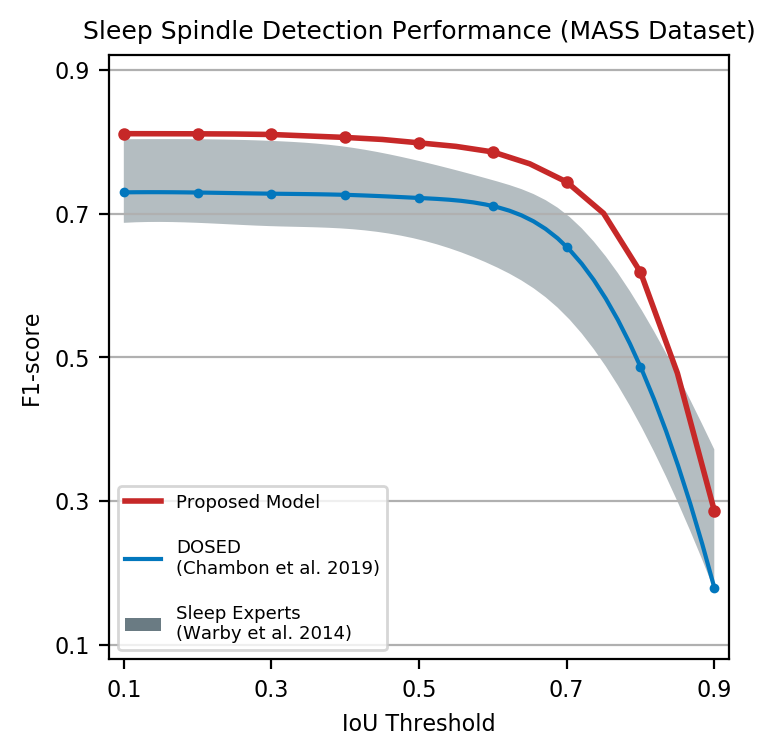

In [18]:
bsf_name = 'Proposed (%s)' % task_mode.upper()

compare_expert = True
compare_chambon = True
show_seed_std = False
show_seed_curves = False
show_ensamble = False
alpha = 0.4
color_list = {'model_mean': CUSTOM_COLOR['red'] , 'expert': CUSTOM_COLOR['grey'], 'dosed': CUSTOM_COLOR['blue']}
linewidth_model = 2.0
markersize_model = 7
linewidth_others = 1.5
markersize_others = 5

# -------------------- P L O T ----------------------    

# Comparison data
compare_expert = (compare_expert and (dataset.event_name == constants.SPINDLE))
if compare_expert:
    expert_f1_curve_mean = np.loadtxt(os.path.join(COMPARISON_PATH, 'expert', 'ss_f1_vs_iou_expert_mean.csv'), delimiter=',')
    expert_f1_curve_std = np.loadtxt(os.path.join(COMPARISON_PATH, 'expert', 'ss_f1_vs_iou_expert_std.csv'), delimiter=',')
    expert_f1_curve_mean = expert_f1_curve_mean[1:, :]
    expert_f1_curve_std = expert_f1_curve_std[1:, :]
if compare_chambon and (dataset_name == constants.MASS_SS_NAME):
    dosed_f1_curve_wn = np.loadtxt(
        os.path.join(COMPARISON_PATH, 'dosed_paper', 'mass_ss_wn_f1_vs_iou_dosed_separately.csv'), delimiter=',')
if compare_chambon and (dataset_name == constants.MASS_KC_NAME):
    dosed_f1_curve_wn = np.loadtxt(
        os.path.join(COMPARISON_PATH, 'dosed_paper', 'mass_kc_wn_f1_vs_iou_dosed_separately.csv'), delimiter=',')
    
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=DPI)


# Complete plot
if compare_expert:
    #ax.plot(expert_f1_curve_mean[:, 0], expert_f1_curve_mean[:, 1], linewidth=linewidth_others, 
    #           label='Expert Performance\nPrivate Dataset\nWarby et al. 2014', color=color_list['expert'])
    #ax.plot(expert_f1_curve_mean[:, 0], expert_f1_curve_mean[:, 1], linestyle='none', 
    #           markersize=markersize_others, marker='.', color=color_list['expert'])
    
    min_border = expert_f1_curve_mean[:, 1] - expert_f1_curve_std[:, 1]
    max_border = expert_f1_curve_mean[:, 1] + expert_f1_curve_std[:, 1]
    fn_min = interp1d(expert_f1_curve_mean[:, 0], min_border, kind='cubic')
    fn_max = interp1d(expert_f1_curve_mean[:, 0], max_border, kind='cubic')
    denser_iou = np.linspace(0.1, 0.9, num=50, endpoint=True)
    min_border = fn_min(denser_iou)
    max_border = fn_max(denser_iou)
    
    ax.fill_between(
        denser_iou, # expert_f1_curve_mean[:, 0], 
        min_border, # expert_f1_curve_mean[:, 1] - expert_f1_curve_std[:, 1], 
        max_border, #expert_f1_curve_mean[:, 1] + expert_f1_curve_std[:, 1], 
        alpha=alpha, facecolor=color_list['expert'], label='Sleep Experts\n(Warby et al. 2014)')

if show_seed_curves:
    for k in seed_id_list:
        ax.plot(iou_list, f1_vs_iou_dict[k], 
           linewidth=linewidth_model, markersize=markersize_model, marker='.', alpha=0.3,
           color=color_list['model_mean'])
        
ax.plot(iou_list, mean_f1_vs_iou, 
           linewidth=linewidth_model,
           label='Proposed Model', color=color_list['model_mean'])
ax.plot(iou_list_short, mean_f1_vs_iou_short, 
           linestyle='none', markersize=markersize_model, marker='.', 
           color=color_list['model_mean'])
idx_to_show = np.where(np.isclose(iou_list, 0.3))[0][0]
print('%1.4f Proposed mean F1 at 0.3' % mean_f1_vs_iou[idx_to_show])
if show_seed_std:
    ax.fill_between(
        iou_list, 
        mean_f1_vs_iou - std_f1_vs_iou, 
        mean_f1_vs_iou + std_f1_vs_iou, 
        alpha=alpha, facecolor=color_list['model_mean'])

if show_ensamble:
    ax.plot(iou_list, half_rule_f1_vs_iou, 
           linewidth=linewidth_model, 
           label='%s (Ensemble)' % bsf_name, color=CUSTOM_COLOR['green'])
    ax.plot(iou_list_short, half_rule_f1_vs_iou_short, 
           linestyle='none', markersize=markersize_model, marker='.', 
           color=CUSTOM_COLOR['green'])
    
if compare_chambon and (dataset_name in [constants.MASS_SS_NAME, constants.MASS_KC_NAME]):
    fn_chambon = interp1d(dosed_f1_curve_wn[:, 0], dosed_f1_curve_wn[:, 1], kind='cubic')
    denser_iou = np.linspace(0.1, 0.9, num=50, endpoint=True)
    inter_chambon = fn_chambon(denser_iou)
    
    ax.plot(
        denser_iou, #dosed_f1_curve_wn[:, 0], 
        inter_chambon, # dosed_f1_curve_wn[:, 1], 
        linewidth=linewidth_others, label='DOSED\n(Chambon et al. 2019)',#'DOSED (WN) (Paper)\nChambon et al. 2019', 
        color=color_list['dosed'])
    ax.plot(dosed_f1_curve_wn[:, 0], dosed_f1_curve_wn[:, 1], linestyle='none',
               markersize=markersize_others, marker='.', color=color_list['dosed'])
    idx_to_show = np.where(np.isclose(dosed_f1_curve_wn[:, 0], 0.3))[0][0]
    print('%1.4f Dosed F1 at 0.3' % dosed_f1_curve_wn[idx_to_show, 1])
    
    
ax.set_title('Sleep Spindle Detection Performance (MASS Dataset)', fontsize=9)
ax.set_xlim([0.1 - 0.02, 0.9 + 0.02])
ax.set_ylim([0.1 - 0.02, 0.9 + 0.02])
ax.set_yticks([0.1*i for i in range(1, 10, 2)])
ax.set_xticks([0.1*i for i in range(1, 10, 2)])
ax.tick_params(labelsize=8)
ax.set_xlabel('IoU Threshold', fontsize=8)
ax.set_ylabel('F1-score', fontsize=8)
ax.yaxis.grid()
lg = ax.legend(loc='lower left', labelspacing=1.5, fontsize=6.5)
lh = lg.legendHandles[2]
lh.set_facecolor(lh.get_facecolor())
lh.set_alpha(0.8)

plt.show()

## Duration scatter

In [ ]:
# Only test set
alpha = 0.2
seed_id_for_scatter = 0


# Prepare model predictions
prediction_obj = predictions_dict[seed_id_for_scatter][constants.VAL_SUBSET]
prediction_obj.set_probability_threshold(optimal_thr_list[seed_id_for_scatter])
this_detections_list = prediction_obj.get_stamps()
this_ids = prediction_obj.get_ids()

# Prepare expert labels
data_inference = FeederDataset(
    dataset, this_ids, task_mode, which_expert)
this_events_list = data_inference.get_stamps()

expert_durations_list = []
predicted_durations_list = []
for i, single_id in enumerate(this_ids):
    single_events = this_events_list[i]
    single_detections = this_detections_list[i]
    this_iou_array, this_idx_array = metrics.matching(single_events, single_detections)
    idx_valid = (this_idx_array > -1)
    matched_expert_durations = (single_events[idx_valid, 1] - single_events[idx_valid, 0]) / fs
    matched_detections = single_detections[this_idx_array]
    matched_predicted_durations = (matched_detections[idx_valid, 1] - matched_detections[idx_valid, 0]) / fs
    expert_durations_list.append(matched_expert_durations)
    predicted_durations_list.append(matched_predicted_durations)

fig, ax = plt.subplots(1, len(this_ids), figsize=(8, 3), dpi=DPI)
for i, subject_id in enumerate(this_ids):
    ax[i].scatter(
        expert_durations_list[i], predicted_durations_list[i], 
        label='S%02d' % subject_id, color='#455a64', alpha=alpha)
    ax[i].tick_params(labelsize=8.5)
    lg = ax[i].legend(fontsize=7)
    for lh in lg.legendHandles:
        lh.set_facecolor(lh.get_facecolor())
        lh.set_edgecolor(lh.get_edgecolor())
        lh.set_alpha(1.0)
    max_dur = max(expert_durations_list[i].max(), predicted_durations_list[i].max())
    ax[i].set_xlim([0, max_dur + 0.1])
    ax[i].set_ylim([0, max_dur + 0.1])
    if i == 0 :
        ax[i].set_ylabel('Detected duration [s]', fontsize=8.5)
    ax[i].set_xlabel('Duration Real [s]', fontsize=8.5)
    ax[i].plot([0.3, 2.0], [0.3, 2.0], '--k', alpha=0.6)

plt.tight_layout()
plt.show()

## F1 vs IoU by subject

In [ ]:
seed_id_for_f1vsiou = 0

# ---------------- Compute performance
f1_vs_iou_subject_dict = {}
pre_vs_iou_subject_dict = {}
rec_vs_iou_subject_dict = {}
iou_list = np.arange(21) * 0.05

# Validation split
# train_ids, val_ids = utils.split_ids_list(
#    all_train_ids, seed=SEED_LIST[seed_id_for_f1vsiou], verbose=False)
if new_split_version:
    train_ids, val_ids = utils.split_ids_list_v2(
        all_train_ids, split_id=seed_id_for_f1vsiou)
else:
    train_ids, val_ids = utils.split_ids_list(
        all_train_ids, seed=SEED_LIST[seed_id_for_f1vsiou])
ids_dict = {
    constants.TRAIN_SUBSET: train_ids,
    constants.VAL_SUBSET: val_ids,
    constants.TEST_SUBSET: test_ids
}

for set_name in set_list:
    print('Processing %s' % set_name, flush=True)
    # Prepare expert labels
    data_inference = FeederDataset(
        dataset, ids_dict[set_name], task_mode, which_expert)
    this_ids = data_inference.get_ids()
    this_events_list = data_inference.get_stamps()
    # Prepare model predictions
    prediction_obj = predictions_dict[seed_id_for_f1vsiou][set_name]
    prediction_obj.set_probability_threshold(optimal_thr_list[seed_id_for_f1vsiou])
    this_detections_list = prediction_obj.get_stamps()
    for i, single_id in enumerate(this_ids):
        single_events = this_events_list[i]
        single_detections = this_detections_list[i]
        this_precision = metrics.metric_vs_iou(single_events, single_detections, iou_list, metric_name=constants.PRECISION)
        this_recall = metrics.metric_vs_iou(single_events, single_detections, iou_list, metric_name=constants.RECALL)
        this_f1 = 2 * this_precision * this_recall / (this_precision + this_recall + 1e-8)
        pre_vs_iou_subject_dict[single_id] = this_precision
        rec_vs_iou_subject_dict[single_id] = this_recall
        f1_vs_iou_subject_dict[single_id] = this_f1
print('Done', flush=True)

color_list = {'train': CUSTOM_COLOR['green'] , 'val': CUSTOM_COLOR['grey'], 'test': CUSTOM_COLOR['red']}
marker_list = ['.', 's', '^', 'x', '*', 'd', 'v', 'p']
linewidth_model = 1
markersize_model = 5

# -------------------- P L O T ----------------------    
    
fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=DPI)

# F1
for set_name in set_list:
    for i, single_id in enumerate(ids_dict[set_name]):
        ax[0].plot(iou_list, f1_vs_iou_subject_dict[single_id], 
                   linewidth=linewidth_model, markersize=markersize_model, marker=marker_list[i], 
                   label='S%02d' % single_id, color=color_list[set_name])

    
ax[0].set_title('Test Performance (%s Dataset) (%s)' 
             % (dataset_name.upper(), task_mode.upper()), fontsize=10)
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_yticks([0.1*i for i in range(1, 10)])
ax[0].set_xticks([0.1*i for i in range(1, 10)])
ax[0].tick_params(labelsize=8.5)
ax[0].set_xlabel('IoU Threshold', fontsize=8.5)
ax[0].set_ylabel('F1-score', fontsize=8.5)
ax[0].yaxis.grid()
ax[0].legend(loc='lower left', fontsize=5)

# Precision
for set_name in set_list:
    for i, single_id in enumerate(ids_dict[set_name]):
        ax[1].plot(iou_list, pre_vs_iou_subject_dict[single_id], 
                   linewidth=linewidth_model, markersize=markersize_model, marker=marker_list[i], 
                   label='S%02d' % single_id, color=color_list[set_name])

    
ax[1].set_title('Test Performance (%s Dataset) (%s)' 
             % (dataset_name.upper(), task_mode.upper()), fontsize=10)
ax[1].set_xlim([0, 1])
ax[1].set_ylim([0, 1])
ax[1].set_yticks([0.1*i for i in range(1, 10)])
ax[1].set_xticks([0.1*i for i in range(1, 10)])
ax[1].tick_params(labelsize=8.5)
ax[1].set_xlabel('IoU Threshold', fontsize=8.5)
ax[1].set_ylabel('Precision', fontsize=8.5)
ax[1].yaxis.grid()
ax[1].legend(loc='lower left', fontsize=5)

# Recall
for set_name in set_list:
    for i, single_id in enumerate(ids_dict[set_name]):
        ax[2].plot(iou_list, rec_vs_iou_subject_dict[single_id], 
                   linewidth=linewidth_model, markersize=markersize_model, marker=marker_list[i], 
                   label='S%02d' % single_id, color=color_list[set_name])

    
ax[2].set_title('Test Performance (%s Dataset) (%s)' 
             % (dataset_name.upper(), task_mode.upper()), fontsize=10)
ax[2].set_xlim([0, 1])
ax[2].set_ylim([0, 1])
ax[2].set_yticks([0.1*i for i in range(1, 10)])
ax[2].set_xticks([0.1*i for i in range(1, 10)])
ax[2].tick_params(labelsize=8.5)
ax[2].set_xlabel('IoU Threshold', fontsize=8.5)
ax[2].set_ylabel('Recall', fontsize=8.5)
ax[2].yaxis.grid()
ax[2].legend(loc='lower left', fontsize=5)

plt.show()

In [ ]:
# PR by subject, usando APrecision y ARecall
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=DPI)
markersize = 10
text_space = 0.01
show_ids = True
axis_lims = [0, 1]
show_set_list = ['train', 'val', 'test']

# F1 score levels
delta = 0.01 
x_ = np.arange(1, 100) * delta 
y_ = np.arange(1, 100) * delta 
X, Y = np.meshgrid(x_, y_)
Z = 2 * X * Y / (X + Y)

levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
levels = [level for level in levels if (level>axis_lims[0] and level<axis_lims[1])]

CS = ax.contour(X, Y, Z, colors='k', alpha=0.3, levels=levels)
ax.clabel(CS, fontsize=6, fmt='%1.2f')

for set_name in set_list:
    if set_name in show_set_list:
        for i, single_id in enumerate(ids_dict[set_name]):
            if i==0:
                label = 'Proposed (%s) (%s)' % (task_mode.upper(), set_name.capitalize())
            else:
                label = None
            this_arecall = rec_vs_iou_subject_dict[single_id].mean()
            this_aprecision = pre_vs_iou_subject_dict[single_id].mean()
            ax.scatter(
                this_arecall, this_aprecision, 
                c=color_list[set_name], 
                label=label, marker='s',
                s=markersize, zorder=10)
            if show_ids:
                ax.annotate(
                    single_id, 
                    (this_arecall+text_space, this_aprecision+text_space), 
                    fontsize=7, color='#1b2631', zorder=20) 
ax.set_title('Seed %d ($\mu$=%1.2f)' % (seed_id_for_f1vsiou, optimal_thr_list[seed_id_for_f1vsiou]), fontsize=7)
ax.set_xlabel('A-Recall', fontsize=7)
ax.set_ylabel('A-Precision', fontsize=7)
ax.set_xlim(axis_lims)
ax.set_ylim(axis_lims)
ax.tick_params(labelsize=7)
ax.legend(loc='lower left', fontsize=5)
ax.grid()
plt.show()

## Performance: Precision-Recall curve, average per set

In [ ]:
iou_thr = 0.3
res_thr = 0.02
start_thr = 0.1
end_thr = 0.9
n_thr = int(np.round((end_thr - start_thr) / res_thr + 1))
thr_list = np.array([start_thr + res_thr * i for i in range(n_thr)])

pr_curve = {}
# Prepare expert labels
data_test = FeederDataset(
    dataset, test_ids, task_mode, which_expert=which_expert)
this_events = data_test.get_stamps()
for k in seed_id_list:
    print('Processing seed %d' % k, flush=True)
    # Columns are [x: recall, y: precision]
    pr_curve[k] = np.zeros((n_thr, 2))
    for i, thr in enumerate(thr_list):
        # Prepare model predictions
        prediction_test = predictions_dict[k][constants.TEST_SUBSET]
        prediction_test.set_probability_threshold(thr)
        this_detections = prediction_test.get_stamps()
        
        this_stats = [metrics.by_event_confusion(this_y, this_y_pred, iou_thr=iou_thr) 
                    for (this_y, this_y_pred) in zip(this_events, this_detections)]
        this_recall = np.mean([m[constants.RECALL] for m in this_stats])
        this_precision = np.mean([m[constants.PRECISION] for m in this_stats])
        pr_curve[k][i, 0] = this_recall
        pr_curve[k][i, 1] = this_precision

# Mean of runs
# pr_curve['mean_runs'] = np.stack([pr_curve[k] for k in seed_id_list], axis=2).mean(axis=2)
print('Done', flush=True)

In [ ]:
# Save
filename = '%s_pr_curve.npy' % (ckpt_folder.split('/')[0])
data = []
this_thr = np.asarray(thr_list)[:, np.newaxis]
for k in seed_id_list:
    this_pr = pr_curve[k]
    this_pr = np.concatenate([this_thr, this_pr], axis=1)
    data.append(this_pr)
data = np.stack(data, axis=0).astype(np.float32)
np.save(filename, data)

In [ ]:
# Plot 
bsf_name = 'Proposed (%s)' % task_mode.upper()
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=DPI)
markersize = 6
alpha = 0.4
text_space = 0.01
compare_chambon = False
show_seeds = True
axis_lims = [0.0, 1.0]
color_list = {'model_mean': CUSTOM_COLOR['red'] , 'dosed': CUSTOM_COLOR['blue']}

# F1 score levels
delta = 0.01 
x_ = np.arange(1, 100) * delta 
y_ = np.arange(1, 100) * delta 
X, Y = np.meshgrid(x_, y_)
Z = 2 * X * Y / (X + Y)

levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
levels = [level for level in levels if (level>axis_lims[0] and level<axis_lims[1])]

CS = ax.contour(X, Y, Z, colors='k', alpha=0.3, levels=levels)
ax.clabel(CS, fontsize=7.5, fmt='%1.2f')

# Chambon
if compare_chambon and (dataset_name == constants.MASS_SS_NAME):
    dosed_rec_prec_wn = np.loadtxt(
        os.path.join(COMPARISON_PATH, 'dosed_paper', 'mass_ss_wn_pr_dosed_separately.csv'), delimiter=',')
    ax.plot(dosed_rec_prec_wn[0], dosed_rec_prec_wn[1], 
           markersize=8, c=color_list['dosed'], zorder=10, 
            label='DOSED (WN) (Paper)', marker='o', linestyle="None")
if compare_chambon and (dataset_name == constants.MASS_KC_NAME):
    dosed_rec_prec_wn = np.loadtxt(
        os.path.join(COMPARISON_PATH, 'dosed_paper', 'mass_kc_wn_pr_dosed_separately.csv'), delimiter=',')
    ax.plot(dosed_rec_prec_wn[0], dosed_rec_prec_wn[1], 
           markersize=8, c=color_list['dosed'], zorder=10, 
            label='DOSED (WN) (Paper)', marker='o', linestyle="None")
    
if show_seeds:
    # Show single seeds
    seed_shown = False
    for k in seed_id_list:
        if not seed_shown:
            seed_shown=True
            label = '%s (Seed curve)' % bsf_name
            label_2 = '%s (Seed O.P.)' % bsf_name
        else:
            label = None
            label_2 = None
        ax.plot(pr_curve[k][:, 0], pr_curve[k][:, 1], 
            label=label,
            linewidth=1, color=color_list['model_mean'], zorder=7, alpha=alpha)
        
        chosen_thr_idx = np.where(np.isclose(thr_list, optimal_thr_list[k]))[0].item()
        ax.scatter(pr_curve[k][chosen_thr_idx, 0], pr_curve[k][chosen_thr_idx, 1], 
                   s=50, c=color_list['model_mean'], zorder=7, alpha=alpha, label=label_2)
    
# Mean of runs
# ax.plot(pr_curve['mean_runs'][:, 0], pr_curve['mean_runs'][:, 1], 
#         label='%s (Mean)' % bsf_name,
#         linewidth=1.5, color=color_list['model_mean'], zorder=10)

# Highlight chosen operating point
# chosen_thr_idx = np.where(np.isclose(thr_list, thr_run))[0].item()
# ax.scatter(pr_curve['mean_runs'][chosen_thr_idx, 0], pr_curve['mean_runs'][chosen_thr_idx, 1], 
#            s=50, c=color_list['model_mean'], zorder=10, label='Operating point $\mu$=%1.2f' % thr_run)
# ax.annotate('$\mu$=%1.3f' % thr_run, 
#             (pr_curve['mean_runs'][chosen_thr_idx, 0], 
#              pr_curve['mean_runs'][chosen_thr_idx, 1] + text_space*2), 
#             fontsize=7, color='#1b2631', zorder=30)  

ax.set_title('Test PR Curve with IoU$>$%1.1f (%s)' % (iou_thr, dataset_name.upper()), fontsize=10)
ax.set_xlabel('Recall', fontsize=8.5)
ax.set_ylabel('Precision', fontsize=8.5)
ax.set_xlim(axis_lims)
ax.set_ylim(axis_lims)

lg = ax.legend(loc='lower left', labelspacing=1, fontsize=6.5)
for lh in lg.legendHandles:
    lh.set_alpha(1.0)

ax.tick_params(labelsize=8.5)
ax.grid()
plt.show()

## Performance: Precision-Recall plot, separated subjects

In [ ]:
iou_thr = 0.3

# Prepare model predictions
be_stats = {}
for k in seed_id_list:
    print('Processing seed %d' % k, flush=True)
    be_stats[k] = {}
    if new_split_version:
        train_ids, val_ids = utils.split_ids_list_v2(
            all_train_ids, split_id=k)
    else:
        train_ids, val_ids = utils.split_ids_list(
            all_train_ids, seed=SEED_LIST[k])
    train_ids.sort()
    val_ids.sort()
    ids_per_set_dict = {
        constants.TRAIN_SUBSET: train_ids,
        constants.VAL_SUBSET: val_ids,
        constants.TEST_SUBSET: test_ids
    }
    for set_name in set_list:
        data_feeder = FeederDataset(
            dataset, ids_per_set_dict[set_name], task_mode, which_expert=which_expert)
        this_events = data_feeder.get_stamps()
        prediction_set = predictions_dict[k][set_name]
        prediction_set.set_probability_threshold(optimal_thr_list[k])
        this_detections = prediction_set.get_stamps()
        be_stats[k][set_name] = [
            metrics.by_event_confusion(this_y, this_y_pred, iou_thr=iou_thr) 
            for (this_y, this_y_pred) in zip(this_events, this_detections)]
print('Done')

In [ ]:
# Plot 
bsf_name = 'Proposed (%s)' % task_mode.upper()
fig, ax = plt.subplots(1, n_seeds, figsize=(2.3*n_seeds, 2.3), dpi=DPI)
markersize = 10
alpha = 0.3
text_space = 0.01
compare_chambon = False
show_ids = True
axis_lims = [0.5, 1.0]
show_set_list = ['train', 'val', 'test']
color_list = {'train': CUSTOM_COLOR['green'] , 'val': CUSTOM_COLOR['grey'], 'test': CUSTOM_COLOR['red'], 'dosed': CUSTOM_COLOR['blue']}

# F1 score levels
delta = 0.01 
x_ = np.arange(1, 100) * delta 
y_ = np.arange(1, 100) * delta 
X, Y = np.meshgrid(x_, y_)
Z = 2 * X * Y / (X + Y)

levels = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
levels = [level for level in levels if (level>axis_lims[0] and level<axis_lims[1])]

# Chambon
if compare_chambon and (dataset_name == constants.MASS_SS_NAME):
    dosed_rec_prec_wn = np.loadtxt(
        os.path.join(COMPARISON_PATH, 'dosed_paper', 'mass_ss_wn_pr_dosed_separately.csv'), delimiter=',')
if compare_chambon and (dataset_name == constants.MASS_KC_NAME):
    dosed_rec_prec_wn = np.loadtxt(
        os.path.join(COMPARISON_PATH, 'dosed_paper', 'mass_kc_wn_pr_dosed_separately.csv'), delimiter=',')
    
for j in range(n_seeds):
    seed_id = seed_id_list[j]
    if new_split_version:
        train_ids, val_ids = utils.split_ids_list_v2(
            all_train_ids, split_id=seed_id)
    else:
        train_ids, val_ids = utils.split_ids_list(
            all_train_ids, seed=SEED_LIST[seed_id])
    train_ids.sort()
    val_ids.sort()
    ids_per_set_dict = {
        constants.TRAIN_SUBSET: train_ids,
        constants.VAL_SUBSET: val_ids,
        constants.TEST_SUBSET: test_ids
    }
    
    
    CS = ax[j].contour(X, Y, Z, colors='k', alpha=0.3, levels=levels)
    ax[j].clabel(CS, fontsize=6, fmt='%1.2f')
    
    if compare_chambon and (dataset_name in [constants.MASS_SS_NAME, constants.MASS_KC_NAME]):
        ax[j].scatter(
            dosed_rec_prec_wn[0], dosed_rec_prec_wn[1], 
            c=color_list['dosed'], 
            label='DOSED (WN)', marker='o',
            s=markersize*3, zorder=10)
    
    for set_name in set_list:
        if set_name in show_set_list:
            for i, stats in enumerate(be_stats[seed_id][set_name]):
                if i==0:
                    label = 'Proposed (%s) (%s)' % (task_mode.upper(), set_name.capitalize())
                else:
                    label = None
                ax[j].scatter(
                    stats['recall'], stats['precision'], 
                    c=color_list[set_name], 
                    label=label, marker='s',
                    s=markersize, zorder=10)
                if show_ids:
                    
                    if j==0:
                        f1_score = 2 * stats['recall'] * stats['precision'] / (stats['recall'] + stats['precision'])
                        print('S%02d (%s) - Recall: %1.4f - Precision: %1.4f - F1: %1.4f' 
                              % (ids_per_set_dict[set_name][i], set_name.ljust(5), stats['recall'], stats['precision'], f1_score))
                    
                    ax[j].annotate(
                        ids_per_set_dict[set_name][i], 
                        (stats['recall']+text_space, stats['precision']+text_space), 
                        fontsize=7, color='#1b2631', zorder=20) 
    ax[j].set_title('Seed %d ($\mu$=%1.2f and IoU>%1.1f)' % (seed_id, optimal_thr_list[j], iou_thr), fontsize=7)
    ax[j].set_xlabel('Recall', fontsize=7)
    ax[j].set_ylabel('Precision', fontsize=7)
    ax[j].set_xlim(axis_lims)
    ax[j].set_ylim(axis_lims)
    ax[j].tick_params(labelsize=7)
    ax[j].grid()

plt.tight_layout()
ax[0].legend(loc='lower left', bbox_to_anchor=(0.5, -0.4), labelspacing=1, fontsize=6, ncol=(1 + len(show_set_list)))
plt.show()


if constants.TEST_SUBSET in show_set_list:
    # mean test
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=DPI)

    CS = ax.contour(X, Y, Z, colors='k', alpha=0.3, levels=levels)
    ax.clabel(CS, fontsize=6, fmt='%1.2f')

    if compare_chambon and (dataset_name in [constants.MASS_SS_NAME, constants.MASS_KC_NAME]):
        ax.scatter(
            dosed_rec_prec_wn[0], dosed_rec_prec_wn[1], 
            c=color_list['dosed'], 
            label='DOSED (WN) (Paper)', marker='o',
            s=markersize*4, zorder=10)
        dosed_f1 = 2 * dosed_rec_prec_wn[0] * dosed_rec_prec_wn[1] / (dosed_rec_prec_wn[0] + dosed_rec_prec_wn[1])
        # print('%1.4f Dosed F1 at 0.3' % dosed_f1)

    set_name = constants.TEST_SUBSET

    recall_list = []
    precision_list = []
    for i in range(len(test_ids)):

        recall_mean = np.stack([be_stats[k][set_name][i]['recall'] for k in seed_id_list]).mean()
        precision_mean = np.stack([be_stats[k][set_name][i]['precision'] for k in seed_id_list]).mean()
        recall_list.append(recall_mean)
        precision_list.append(precision_mean)
        if i==0:
            label = '%s (Single subject)' % bsf_name
        else:
            label = None
        ax.scatter(
            recall_mean, precision_mean, 
            c=color_list[set_name], 
            label=label, marker='s',
            s=markersize, zorder=10)
        if show_ids:
            ax.annotate(
                ids_per_set_dict[set_name][i], 
                (recall_mean+text_space, precision_mean+text_space), 
                fontsize=7, color='#1b2631', zorder=20)

    # mean of subjects

    ax.scatter(
        np.mean(recall_list), np.mean(precision_list), 
        c=color_list[set_name], 
        label='%s (Mean of subjects)' % bsf_name, marker='o',
        s=markersize*4, zorder=10)

    ax.set_title('Mean Test PR for IoU>%1.1f (%s Detection)' % (iou_thr, dataset_name[-2:].upper()), fontsize=8)
    ax.set_xlabel('Recall', fontsize=7)
    ax.set_ylabel('Precision', fontsize=7)
    ax.set_xlim(axis_lims)
    ax.set_ylim(axis_lims)
    ax.tick_params(labelsize=7)
    ax.grid()
    ax.legend(loc='lower left', fontsize=7)
    plt.show()
    
    each_recall = np.asarray(recall_list)
    each_precision = np.asarray(precision_list)
    model_f1 = np.mean(2 * each_recall * each_precision / (each_recall + each_precision))
    # print('%1.4f Proposed mean F1 at 0.3' % model_f1)

## Separability

In [ ]:
seed_to_show = 2
set_name = 'val'
subject_id = 7

# -----
print(ckpt_folder)

if dataset_name in [constants.MASS_SS_NAME, constants.MASS_KC_NAME]:
    channel_name = 'C3-CLE'
elif dataset_name in [constants.DREAMS_SS_NAME, constants.DREAMS_KC_NAME]:
    channel_name = 'Cz-A1'
else:
    channel_name = 'F4-C4'


pages_subset = constants.N2_RECORD

if new_split_version:
    train_ids, val_ids = utils.split_ids_list_v2(
        all_train_ids, split_id=seed_to_show)
else:
    train_ids, val_ids = utils.split_ids_list(
        all_train_ids, seed=SEED_LIST[seed_to_show])

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids, 'alltrain': all_train_ids}
idx_subject = idx_dict[set_name].index(subject_id)

this_pages = dataset.get_subject_pages(subject_id=subject_id, pages_subset=pages_subset)
this_signal = dataset.get_subject_signal(subject_id=subject_id, normalization_mode=task_mode, which_expert=which_expert)
this_stamps = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=pages_subset, which_expert=which_expert)
this_stamps_full = this_stamps.copy()
event_name = dataset.event_name

this_thr = optimal_thr_list[seed_to_show]
smaller_proba_for_fp = this_thr / 2
prediction_set = predictions_dict[seed_to_show][set_name]
down_factor = prediction_set.params[pkeys.TOTAL_DOWNSAMPLING_FACTOR]
predicted_proba = prediction_set.get_subject_probabilities(subject_id)

# Look for probability in real events
mean_proba_real_list = []
max_proba_real_list = []
for single_stamp in this_stamps_full:
    proba_segment_idx = single_stamp // 8
    proba_segment = predicted_proba[proba_segment_idx[0]:proba_segment_idx[1]+1]
    mean_proba_real_list.append(np.mean(proba_segment))
    max_proba_real_list.append(np.max(proba_segment))

# Look for probability of fake events
mean_proba_fake_list = []
max_proba_fake_list = []
prediction_set.set_probability_threshold(smaller_proba_for_fp)
this_detections = prediction_set.get_subject_stamps(subject_id)
# Matching:
this_iou_array, this_idx_array = metrics.matching(this_stamps_full, this_detections)
this_expert_iou = this_iou_array
n_detections = this_detections.shape[0]
this_detection_iou = np.zeros(n_detections)
for i in range(n_detections):
    if i in this_idx_array:
        matching_idx = np.where(this_idx_array == i)[0][0]
        this_detection_iou[i] = this_iou_array[matching_idx] 
# Recover events with zero iou
fake_idx = np.where(this_detection_iou == 0)[0]
this_fake_stamps = this_detections[fake_idx]
for single_stamp in this_fake_stamps:
    proba_segment_idx = single_stamp // 8
    proba_segment = predicted_proba[proba_segment_idx[0]:proba_segment_idx[1]+1]
    mean_proba_fake_list.append(np.mean(proba_segment))
    max_proba_fake_list.append(np.max(proba_segment))
    

proba_bins = np.linspace(0.0, 1.0, num=21, endpoint=True) 
fig, ax = plt.subplots(2, 2, figsize=(8, 8), dpi=100, sharey=True, sharex=True)
values, _, _ = ax[0, 0].hist(mean_proba_real_list, bins=proba_bins, color=CUSTOM_COLOR['blue'], label='S%02d' % subject_id)
ax[0, 0].tick_params(labelsize=8.5)
ax[0, 0].legend(fontsize=8.5)
ax[0, 0].set_xlim([0, 1])
ax[0, 0].set_xlabel('Probability', fontsize=8.5)
n_after_thr = np.sum(np.array(mean_proba_real_list) >= this_thr)
ax[0, 0].set_title('Mean Proba of Real (%d greater than %1.2f)' % (n_after_thr, this_thr), fontsize=9)
ax[0, 0].plot([this_thr, this_thr], [0, np.max(values)*1.05], '--k')

values, _, _ = ax[0, 1].hist(max_proba_real_list, bins=proba_bins, color=CUSTOM_COLOR['blue'], label='S%02d' % subject_id)
ax[0, 1].tick_params(labelsize=8.5)
ax[0, 1].legend(fontsize=8.5)
ax[0, 1].set_xlim([0, 1])
ax[0, 1].set_xlabel('Probability', fontsize=8.5)
n_after_thr = np.sum(np.array(max_proba_real_list) >= this_thr)
ax[0, 1].set_title('Max Proba of Real (%d greater than %1.2f)' % (n_after_thr, this_thr), fontsize=9)
ax[0, 1].plot([this_thr, this_thr], [0, np.max(values)*1.05], '--k')

values, _, _ = ax[1, 0].hist(mean_proba_fake_list, bins=proba_bins, color=CUSTOM_COLOR['red'], label='S%02d' % subject_id)
ax[1, 0].tick_params(labelsize=8.5)
ax[1, 0].legend(fontsize=8.5)
ax[1, 0].set_xlim([0, 1])
ax[1, 0].set_xlabel('Probability', fontsize=8.5)
n_after_thr = np.sum(np.array(mean_proba_fake_list) >= this_thr)
ax[1, 0].set_title('Mean Proba of Fake (%d greater than %1.2f)' % (n_after_thr, this_thr), fontsize=9)
ax[1, 0].plot([this_thr, this_thr], [0, np.max(values)*1.05], '--k')

values, _, _ = ax[1, 1].hist(max_proba_fake_list, bins=proba_bins, color=CUSTOM_COLOR['red'], label='S%02d' % subject_id)
ax[1, 1].tick_params(labelsize=8.5)
ax[1, 1].legend(fontsize=8.5)
ax[1, 1].set_xlim([0, 1])
ax[1, 1].set_xlabel('Probability', fontsize=8.5)
n_after_thr = np.sum(np.array(max_proba_fake_list) >= this_thr)
ax[1, 1].set_title('Max Proba of Fake (%d greater than %1.2f)' % (n_after_thr, this_thr), fontsize=9)
ax[1, 1].plot([this_thr, this_thr], [0, np.max(values)*1.05], '--k')

plt.tight_layout()
plt.show()

## Visualization of subject

In [ ]:
seed_to_show = 0
set_name = 'test'
subject_id = 12
show_only_n2 = True
show_hypno = False
band_pass_freqs = [12, 14]

# -----
if dataset_name in [constants.MASS_SS_NAME, constants.MASS_KC_NAME]:
    channel_name = 'C3-CLE'
else:
    channel_name = 'F4-C4'

if show_only_n2:
    pages_subset = constants.N2_RECORD
else:
    pages_subset = constants.WN_RECORD

if new_split_version:
    train_ids, val_ids = utils.split_ids_list_v2(
        all_train_ids, split_id=seed_to_show)
else:
    train_ids, val_ids = utils.split_ids_list(
        all_train_ids, seed=SEED_LIST[seed_to_show])    

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids, 'alltrain': all_train_ids}
idx_subject = idx_dict[set_name].index(subject_id)

this_pages = dataset.get_subject_pages(subject_id=subject_id, pages_subset=pages_subset)
if show_hypno:
    this_hypnogram = dataset.get_subject_hypnogram(subject_id=subject_id)
this_signal = dataset.get_subject_signal(subject_id=subject_id, normalization_mode=task_mode, which_expert=which_expert)
this_stamps = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=pages_subset, which_expert=which_expert)
if (subject_id not in [4, 8, 15, 16]) and dataset_name == constants.MASS_SS_NAME:
    this_stamps_2 = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=pages_subset, which_expert=2)
else:
    this_stamps_2 = None

event_name = dataset.event_name

this_thr = optimal_thr_list[seed_to_show]
prediction_set = predictions_dict[seed_to_show][set_name]
prediction_set.set_probability_threshold(this_thr)
this_predicted_stamps = prediction_set.get_subject_stamps(subject_id=subject_id, pages_subset=constants.WN_RECORD)
this_proba = prediction_set.get_subject_probabilities(subject_id=subject_id)

fs_real = dataset.fs
down_factor = prediction_set.params[pkeys.TOTAL_DOWNSAMPLING_FACTOR]
fs_proba = fs_real / down_factor

# make a color map of fixed colors
cmap = colors.ListedColormap(['white', '#c62828'])


def filter_stamps(stamps, single_page, page_size):
    pages_list = []
    for i in range(stamps.shape[0]):
        stamp_start_page = stamps[i, 0] // page_size
        stamp_end_page = stamps[i, 1] // page_size

        start_inside = (stamp_start_page == single_page)
        end_inside = (stamp_end_page == single_page)

        if start_inside or end_inside:
            pages_list.append(stamps[i, :])
    return pages_list


def plot_page(page_idx):

    if this_stamps_2 is None:
        fig = plt.figure(figsize=(12, 4), dpi=DPI)
        gs = gridspec.GridSpec(3, 1, height_ratios=[4, 2, 1])
    else:
        fig = plt.figure(figsize=(12, 5), dpi=DPI)
        gs = gridspec.GridSpec(4, 1, height_ratios=[4, 2, 1, 1])
    
    page_idx = page_idx - 1
    page_chosen = this_pages[page_idx]
    if show_hypno:
        page_state = this_hypnogram[page_of_center]
    else:
        page_state = '?'
    page_start = page_chosen * dataset.page_size
    page_end = page_start + dataset.page_size
    
    segment_signal = this_signal[page_start:page_end]
    
    segment_stamps = filter_stamps(this_stamps, page_chosen, dataset.page_size)
    if this_stamps_2 is not None:
        segment_stamps_2 = filter_stamps(this_stamps_2, page_chosen, dataset.page_size)
    segment_proba = this_proba[int(page_start/down_factor):int(page_end/down_factor)]
    segment_predicted_stamps = filter_stamps(this_predicted_stamps, page_chosen, dataset.page_size)
    
    time_axis_real = np.arange(page_start, page_end) / fs_real
    time_axis_proba = np.arange(int(page_start/down_factor), int(page_end/down_factor)) / fs_proba
    
    gs_idx = 0
    
    # Signal
    y_max = 10
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    ax.plot(
        time_axis_real, segment_signal, 
        linewidth=1, color=CUSTOM_COLOR['grey'], label='EEG %s' % channel_name)
    stamp_label_used = False
    for expert_stamp in segment_stamps:
        if stamp_label_used:
            label = None
        else:
            label = event_name
            stamp_label_used = True
        ax.fill_between(
            expert_stamp / fs_real, y_max, -y_max, 
            facecolor=CUSTOM_COLOR['blue'], alpha=0.3, label=label,
            edgecolor='k', linewidth=1.5, 
        )
    ax.set_yticks([])
    ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
    ax.set_ylim([-y_max, y_max])
    ax.set_title('Subject %d (%s-%s). Page in record: %d. State %s (intervals of 0.5s are shown).' 
                 % (subject_id, dataset_name.upper(), set_name.capitalize(), page_chosen, page_state), fontsize=10)
    ax.set_xticks([
        time_axis_real[0], 
        time_axis_real[0] + 5, 
        time_axis_real[0] + 10, 
        time_axis_real[0] + 15, 
        time_axis_real[0] + 20])
    ax.set_xticks(np.arange(time_axis_real[0], time_axis_real[-1], 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    lg = ax.legend(loc='upper right', fontsize=8.5)
    # lh = lg.legendHandles[1]
    # lh.set_facecolor(lh.get_facecolor())
    # lh.set_alpha(1.0)
    ax.tick_params(labelsize=8.5)
    
    # Band pass Signal
    y_max = 10
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    # segment_signal_filtered = utils.narrow_filter(segment_signal, fs_real, band_pass_freqs[0], band_pass_freqs[1])
    segment_signal_filtered = utils.filter_windowed_sinusoidal(segment_signal, fs_real, 13, 41)
    ax.plot(
        time_axis_real, segment_signal_filtered, 
        linewidth=1, color=CUSTOM_COLOR['grey'], label='EEG %s' % channel_name)
    stamp_label_used = False
    for expert_stamp in segment_stamps:
        if stamp_label_used:
            label = None
        else:
            label = event_name
            stamp_label_used = True
        ax.fill_between(
            expert_stamp / fs_real, y_max, -y_max, 
            facecolor=CUSTOM_COLOR['blue'], alpha=0.3, label=label,
            edgecolor='k', linewidth=1.5, 
        )
    ax.set_yticks([])
    ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
    ax.set_ylim([-y_max, y_max])
    ax.set_title('Bandpass filtered signal (sigma)', fontsize=10)
    ax.set_xticks([
        time_axis_real[0], 
        time_axis_real[0] + 5, 
        time_axis_real[0] + 10, 
        time_axis_real[0] + 15, 
        time_axis_real[0] + 20])
    ax.set_xticks(np.arange(time_axis_real[0], time_axis_real[-1], 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    lg = ax.legend(loc='upper right', fontsize=8.5)
    # lh = lg.legendHandles[1]
    # lh.set_facecolor(lh.get_facecolor())
    # lh.set_alpha(1.0)
    ax.tick_params(labelsize=8.5)
    
    # Neural net
    delta_y = 0.1
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    ax.plot(
        time_axis_proba, segment_proba, 
        color=CUSTOM_COLOR['red'], linewidth=1.5, zorder=7)
    for model_stamp in segment_predicted_stamps:
        ax.fill_between(
            model_stamp / fs_real, 1+delta_y, -delta_y, 
            facecolor=CUSTOM_COLOR['red'], zorder=6, alpha=0.3,
            edgecolor='k', linewidth=1.5, 
        )
    ax.set_xticks([])
    ax.set_ylim([-delta_y, 1+delta_y])
    ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
    ax.set_yticks([0, 1])
    ax.set_yticks([this_thr], minor=True)
    ax.grid(b=True, axis='y', linewidth=1.5, which='minor', zorder=5)
    ax.tick_params(labelsize=8.5)
    ax.set_title('Model prediction: probability and postprocessed stamps (%1.2f threshold is shown)' % this_thr, fontsize=10)
    
    if this_stamps_2 is not None:
        ax = fig.add_subplot(gs[gs_idx])
        # ax.imshow(segment_marks_2[np.newaxis, :], interpolation=None, aspect='auto', cmap=cmap)
        for expert_stamp in segment_stamps_2:
            ax.fill_between(
                expert_stamp / fs_real, y_max, -y_max, 
                facecolor=CUSTOM_COLOR['blue'], alpha=0.3,
                edgecolor='k', linewidth=1.5, 
            )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylim([-delta_y, 1+delta_y])
        ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
        ax.set_title('Second expert stamps (not used for training)', fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [ ]:
widgets.interact(
    lambda page_idx: plot_page(page_idx),
    page_idx=widgets.IntSlider(min=1,max=this_pages.shape[0],step=1,value=447, continuous_update=False));

## Visualization centered

In [ ]:
seed_to_show = 0
set_name = 'test'
subject_id = 12
center_on_real = False
iou_range = [0, 0]
duration_range = [0, 5]
show_hypno = True


band_pass_freqs = [12, 14]

# -----
if dataset_name in [constants.MASS_SS_NAME, constants.MASS_KC_NAME]:
    channel_name = 'C3-CLE'
elif dataset_name in [constants.DREAMS_SS_NAME, constants.DREAMS_KC_NAME]:
    channel_name = 'Cz-A1'
else:
    channel_name = 'F4-C4'


pages_subset = constants.N2_RECORD

if new_split_version:
    train_ids, val_ids = utils.split_ids_list_v2(
        all_train_ids, split_id=seed_to_show)
else:
    train_ids, val_ids = utils.split_ids_list(
        all_train_ids, seed=SEED_LIST[seed_to_show])

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids, 'alltrain': all_train_ids}
idx_subject = idx_dict[set_name].index(subject_id)

this_pages = dataset.get_subject_pages(subject_id=subject_id, pages_subset=pages_subset)
if show_hypno:
    this_hypnogram = dataset.get_subject_hypnogram(subject_id=subject_id)
this_signal = dataset.get_subject_signal(subject_id=subject_id, normalization_mode=task_mode, which_expert=which_expert)
this_stamps = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=pages_subset, which_expert=which_expert)
this_stamps_full = this_stamps.copy()
if (subject_id not in [4, 8, 15, 16]) and dataset_name == constants.MASS_SS_NAME:
    this_stamps_2 = dataset.get_subject_stamps(subject_id=subject_id, pages_subset=pages_subset, which_expert=2)
    this_stamps_2_full = this_stamps_2.copy()
else:
    this_stamps_2 = None

event_name = dataset.event_name

this_thr = optimal_thr_list[seed_to_show]
prediction_set = predictions_dict[seed_to_show][set_name]
prediction_set.set_probability_threshold(this_thr)
this_predicted_stamps = prediction_set.get_subject_stamps(subject_id=subject_id, pages_subset=constants.WN_RECORD)
this_predicted_stamps_full = this_predicted_stamps.copy()
this_proba = prediction_set.get_subject_probabilities(subject_id=subject_id)

fs_real = dataset.fs
down_factor = prediction_set.params[pkeys.TOTAL_DOWNSAMPLING_FACTOR]
fs_proba = fs_real / down_factor

# make a color map of fixed colors
cmap = colors.ListedColormap(['white', '#c62828'])

# Matching:
this_iou_array, this_idx_array = metrics.matching(this_stamps, this_predicted_stamps)
this_expert_iou = this_iou_array
n_detections = this_predicted_stamps.shape[0]
this_dectection_iou = np.zeros(n_detections)

for i in range(n_detections):
    if i in this_idx_array:
        matching_idx = np.where(this_idx_array == i)[0][0]
        this_dectection_iou[i] = this_iou_array[matching_idx]        

# Number of missed reals:
n_ufn = np.sum(this_expert_iou == 0)
# Number of false detections:
n_ufp = np.sum(this_dectection_iou == 0)
# Number of matched pairs
n_matched = np.sum(this_expert_iou > 0)
n_matched_v2 = np.sum(this_dectection_iou > 0)
print('UFN:', n_ufn)
print('UFP', n_ufp)
print('Matched', n_matched, n_matched_v2)
precision = n_matched / (n_matched + n_ufp)
recall = n_matched / (n_matched + n_ufn)
f1_at_iou0 = 2 * precision * recall / (precision + recall)
print('F1 at IoU>0 %1.2f' % f1_at_iou0)

# Fraction of UFP that does not match E1 but match E2
print('** UFP and E2 intersection analysis ** ')
all_ufp = this_predicted_stamps_full[this_dectection_iou == 0]
overlap_ufp_e1 = utils.get_overlap_matrix(all_ufp, this_stamps_full)
valid_ufp = np.where(overlap_ufp_e1.sum(axis=1) == 0)[0]
print('UFP removed because E1 intersection: %d' % (all_ufp.shape[0] - valid_ufp.size))
all_ufp = all_ufp[valid_ufp]
overlap_ufp_e2 = utils.get_overlap_matrix(all_ufp, this_stamps_2_full)
idx_with_e2_intersection = np.where(overlap_ufp_e2.sum(axis=1) > 0)[0]
print('UFP with intersection with E2 and none with E1: %d (%1.2f %%)' % (idx_with_e2_intersection.size, 100*idx_with_e2_intersection.size/n_ufp))


fig, ax = plt.subplots(1, 1, figsize=(3, 1), dpi=200)
ax.hist(this_expert_iou[this_expert_iou > 0], bins=[0.1*i for i in range(11)], color=CUSTOM_COLOR['red'], label='S%02d' % subject_id)
ax.legend(loc='upper left', fontsize=7)
ax.set_title('IoU of Matchings', fontsize=8)
ax.set_xticks([0.1*i for i in range(0, 11, 2)])
ax.set_xlabel('IoU', fontsize=7)
ax.tick_params(labelsize=7)
plt.show()
        
# filter
if center_on_real:
    idx_useful_iou = np.where( (this_expert_iou >= iou_range[0]) & (this_expert_iou <= iou_range[1]) )[0]
    duration_expert = (this_stamps[:, 1] - this_stamps[:, 0]) / fs_real
    idx_useful_duration = np.where( (duration_expert >= duration_range[0]) & (duration_expert <= duration_range[1]) )[0]
    idx_useful = [i for i in idx_useful_iou if i in idx_useful_duration]
    this_stamps = this_stamps[idx_useful]
    this_expert_iou = this_expert_iou[idx_useful]
else:
    idx_useful_iou = np.where( (this_dectection_iou >= iou_range[0]) & (this_dectection_iou <= iou_range[1]) )[0]
    duration_det = (this_predicted_stamps[:, 1] - this_predicted_stamps[:, 0]) / fs_real
    idx_useful_duration = np.where( (duration_det >= duration_range[0]) & (duration_det <= duration_range[1]) )[0]
    idx_useful = [i for i in idx_useful_iou if i in idx_useful_duration]
    this_predicted_stamps = this_predicted_stamps[idx_useful]
    this_dectection_iou = this_dectection_iou[idx_useful]

def filter_stamps(stamps, start_sample, end_sample):
    pages_list = []
    for i in range(stamps.shape[0]):
        start_inside = (stamps[i, 0] > start_sample) and (stamps[i, 0] < end_sample)
        end_inside = (stamps[i, 1] > start_sample) and (stamps[i, 1] < end_sample)

        if start_inside or end_inside:
            pages_list.append(stamps[i, :])
    return pages_list


def plot_event(event_idx):

    if this_stamps_2 is None:
        fig = plt.figure(figsize=(12, 4), dpi=DPI)
        gs = gridspec.GridSpec(3, 1, height_ratios=[4, 2, 1])
    else:
        fig = plt.figure(figsize=(12, 5), dpi=DPI)
        gs = gridspec.GridSpec(4, 1, height_ratios=[4, 2, 1, 1])
    
    event_idx = event_idx - 1
    
    if center_on_real:
        event_chosen = this_stamps[event_idx, :]
        iou_chosen = this_expert_iou[event_idx]
    else:
        event_chosen = this_predicted_stamps[event_idx, :]
        iou_chosen = this_dectection_iou[event_idx]

    start_sample = int(event_chosen[0] - 10 * fs_real)
    end_sample = int(event_chosen[1] + 10 * fs_real)

    page_of_center = int(((end_sample + start_sample) / 2) / dataset.page_size)
    if show_hypno:
        page_state = this_hypnogram[page_of_center]
    else:
        page_state = '?'
    
    segment_signal = this_signal[start_sample:end_sample]
    segment_stamps = filter_stamps(this_stamps_full, start_sample, end_sample)
    if this_stamps_2 is not None:
        segment_stamps_2 = filter_stamps(this_stamps_2_full, start_sample, end_sample)
    segment_proba = this_proba[int(start_sample/down_factor):int(end_sample/down_factor)]
    segment_predicted_stamps = filter_stamps(this_predicted_stamps_full, start_sample, end_sample)
    
    time_axis_real = np.arange(start_sample, end_sample) / fs_real
    time_axis_proba = np.arange(int(start_sample/down_factor), int(end_sample/down_factor)) / fs_proba
    
    gs_idx = 0
    
    # Signal
    y_max = 7
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    ax.plot(
        time_axis_real, segment_signal, 
        linewidth=1, color=CUSTOM_COLOR['grey'], label='EEG %s' % channel_name)
    stamp_label_used = False
    for expert_stamp in segment_stamps:
        if stamp_label_used:
            label = None
        else:
            label = event_name
            stamp_label_used = True
        ax.fill_between(
            expert_stamp / fs_real, y_max, -y_max, 
            facecolor=CUSTOM_COLOR['blue'], alpha=0.3, label=label,
            edgecolor='k', linewidth=1.5, 
        )
    ax.set_yticks([])
    ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
    ax.set_ylim([-y_max, y_max])
    if center_on_real:
        ax.set_title('Subject %d (%s-%s). Expert mark idx: %d. IoU %1.2f. State %s (intervals of 0.5s are shown).' 
                     % (subject_id, dataset_name.upper(), set_name.capitalize(), event_idx, iou_chosen, page_state), fontsize=10)
    else:
        ax.set_title('Subject %d (%s-%s). Detection idx: %d. IoU %1.2f. State %s (intervals of 0.5s are shown).' 
                     % (subject_id, dataset_name.upper(), set_name.capitalize(), event_idx, iou_chosen, page_state), fontsize=10)
        
    ax.set_xticks([
        time_axis_real[0], 
        time_axis_real[0] + 5, 
        time_axis_real[0] + 10, 
        time_axis_real[0] + 15, 
        time_axis_real[0] + 20])
    ax.set_xticks(np.arange(time_axis_real[0], time_axis_real[-1], 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    lg = ax.legend(loc='upper right', fontsize=8.5)
    # lh = lg.legendHandles[1]
    # lh.set_facecolor(lh.get_facecolor())
    # lh.set_alpha(1.0)
    ax.tick_params(labelsize=8.5)
    
    # Band pass Signal
    y_max = 5
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    # segment_signal_filtered = utils.narrow_filter(segment_signal, fs_real, band_pass_freqs[0], band_pass_freqs[1])
    segment_signal_filtered = utils.filter_windowed_sinusoidal(segment_signal, fs_real, 13, 41)
    ax.plot(
        time_axis_real, segment_signal_filtered, 
        linewidth=1, color=CUSTOM_COLOR['grey'], label='EEG %s' % channel_name)
    stamp_label_used = False
    for expert_stamp in segment_stamps:
        if stamp_label_used:
            label = None
        else:
            label = event_name
            stamp_label_used = True
        ax.fill_between(
            expert_stamp / fs_real, y_max, -y_max, 
            facecolor=CUSTOM_COLOR['blue'], alpha=0.3, label=label,
            edgecolor='k', linewidth=1.5, 
        )
    ax.set_yticks([])
    ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
    ax.set_ylim([-y_max, y_max])
    ax.set_title('Bandpass filtered signal (sigma)', fontsize=10)
    ax.set_xticks([
        time_axis_real[0], 
        time_axis_real[0] + 5, 
        time_axis_real[0] + 10, 
        time_axis_real[0] + 15, 
        time_axis_real[0] + 20])
    ax.set_xticks(np.arange(time_axis_real[0], time_axis_real[-1], 0.5), minor=True)
    ax.grid(b=True, axis='x', which='minor')
    lg = ax.legend(loc='upper right', fontsize=8.5)
    # lh = lg.legendHandles[1]
    # lh.set_facecolor(lh.get_facecolor())
    # lh.set_alpha(1.0)
    ax.tick_params(labelsize=8.5)
    
    # Neural net
    delta_y = 0.1
    ax = fig.add_subplot(gs[gs_idx])
    gs_idx = gs_idx + 1
    ax.plot(
        time_axis_proba, segment_proba, 
        color=CUSTOM_COLOR['red'], linewidth=1.5, zorder=7)
    for model_stamp in segment_predicted_stamps:
        ax.fill_between(
            model_stamp / fs_real, 1+delta_y, -delta_y, 
            facecolor=CUSTOM_COLOR['red'], zorder=6, alpha=0.3,
            edgecolor='k', linewidth=1.5, 
        )
    ax.set_xticks([])
    ax.set_ylim([-delta_y, 1+delta_y])
    ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
    ax.set_yticks([0, 1])
    ax.set_yticks([this_thr], minor=True)
    ax.grid(b=True, axis='y', linewidth=1.5, which='minor', zorder=5)
    ax.tick_params(labelsize=8.5)
    ax.set_title('Model prediction: probability and postprocessed stamps (%1.2f threshold is shown)' % this_thr, fontsize=10)
    
    if this_stamps_2 is not None:
        ax = fig.add_subplot(gs[gs_idx])
        # ax.imshow(segment_marks_2[np.newaxis, :], interpolation=None, aspect='auto', cmap=cmap)
        for expert_stamp in segment_stamps_2:
            ax.fill_between(
                expert_stamp / fs_real, y_max, -y_max, 
                facecolor=CUSTOM_COLOR['blue'], alpha=0.3,
                edgecolor='k', linewidth=1.5, 
            )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylim([-delta_y, 1+delta_y])
        ax.set_xlim([time_axis_real[0], time_axis_real[-1]])
        ax.set_title('Second expert stamps (not used for training)', fontsize=10)
    
    plt.tight_layout()
    plt.show()

In [ ]:
print('Showing events with IoU in range %s' % iou_range)
print('Showing events with duration in range %s [s]' % duration_range)
if center_on_real:
    max_value = this_stamps.shape[0]
    print('Number of real events selected %d' % max_value)
else:
    max_value = this_predicted_stamps.shape[0]
    print('Number of detected events selected %d' % max_value)

widgets.interact(
    lambda event_idx: plot_event(event_idx),
    event_idx=widgets.IntSlider(min=1,max=max_value,step=1,value=1, continuous_update=False));

# Error analysis

### Postprocessing sensitivity

In [ ]:
chosen_set_error = 'test'
thr = optimal_thr_list[0]

y_thr = y_stamps[chosen_set_error]

# Prepare model predictions
n_subjects = len(y_thr)
pred_stamps = []
for i in range(n_subjects):
    print('Processing subject %d/%d' % (i+1, n_subjects), flush=True)
    # Binarize
    this_y_pred_thr = (y_pred[chosen_set_error][i] >= thr).astype(np.int32)
    # Transform to intervals
    this_y_pred_thr = data_ops.seq2inter_with_pages(
        this_y_pred_thr, pages[chosen_set_error][i]
    )
    pred_stamps.append(this_y_pred_thr)
fs_pred = 200 // 8 
fs_real = 200
print('Done')

In [ ]:
# ------------------------- Compute spacing ----------------------
combine_thr = 0.3

spacing = []
spacing_expert = []
for i in range(n_subjects):
    print('Spacing for subject %d/%d' % (i+1, n_subjects), flush=True)
    this_spacing = (pred_stamps[i][1:, 0] - pred_stamps[i][:-1, 1]) / fs_pred
    this_spacing_expert = (y_stamps[chosen_set_error][i][1:, 0] - y_stamps[chosen_set_error][i][:-1, 1]) / fs_real
    # Only consider for this analysis, spacing less than one second
    this_spacing = this_spacing[this_spacing < 1]
    this_spacing_expert = this_spacing_expert[this_spacing_expert < 1]
    spacing.append(this_spacing)
    spacing_expert.append(this_spacing_expert)
print('Done')

fig, ax = plt.subplots(n_subjects, 2, figsize=(8, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0, 0].set_title('Spacing between nearby expert marks', fontsize=10)
ax[0, 1].set_title('Spacing between nearby detections', fontsize=10)
y_max = 0
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # Real
    n_real, _, _ = ax[i, 0].hist(spacing_expert[i], bins=[k*0.1 for k in range(11)], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 0].set_xticks([k*0.2 for k in range(6)])
    ax[i, 0].tick_params(labelsize=8.5)
    ax[i, 0].legend(fontsize=8.5)
    # Predicted
    n_pred, _, _ = ax[i, 1].hist(spacing[i], bins=[k*0.1 for k in range(11)], color='#c62828', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 1].set_xticks([k*0.2 for k in range(6)])
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5)
    max_y = max(np.max(n_real), np.max(n_pred))
    ax[i, 0].plot([combine_thr, combine_thr], [0, max_y], '--', color='k', linewidth=2, alpha=0.6)
    ax[i, 1].plot([combine_thr, combine_thr], [0, max_y], '--', color='k', linewidth=2, alpha=0.6)
    # y_max = max(max_y, y_max)
# for i in range(n_subjects):
#     ax[i, 0].plot([combine_thr, combine_thr], [0, y_max], '--', color='k', linewidth=2, alpha=0.6)
#     ax[i, 1].plot([combine_thr, combine_thr], [0, y_max], '--', color='k', linewidth=2, alpha=0.6)
ax[-1, 0].set_xlabel('Spacing [s]', fontsize=8.5)
ax[-1, 1].set_xlabel('Spacing [s]', fontsize=8.5)
plt.show()

In [ ]:
# -------------- Durations

if dataset_name == constants.MASSK_NAME:
    postprocess_predicted = False
else:
    postprocess_predicted = True

durations = []
durations_expert = []
for i in range(n_subjects):
    print('Durations for subject %d/%d' % (i+1, n_subjects), flush=True)
    # First, combine close marks
    if dataset_name == constants.MASSK_NAME:
        this_pred_stamps = pred_stamps[i]
    else:
        this_pred_stamps = postprocessing.combine_close_marks(pred_stamps[i], fs_pred, combine_thr)
    # Now compute durations
    this_durations = (this_pred_stamps[:, 1] - this_pred_stamps[:, 0]) / fs_pred
    this_durations_expert = (y_stamps[chosen_set_error][i][:, 1] - y_stamps[chosen_set_error][i][:, 0]) / fs_real
    # Only consider for this analysis, spacing less than one second
    durations.append(this_durations)
    durations_expert.append(this_durations_expert)
print('Done')

fig, ax = plt.subplots(n_subjects, 2, figsize=(8, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0, 0].set_title('Duration of expert marks', fontsize=10)
ax[0, 1].set_title('Duration of detections', fontsize=10)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
y_max = 0
min_duration = 0.3  
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # Real
    n_real, _, _ = ax[i, 0].hist(durations_expert[i], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 0].tick_params(labelsize=8.5)
    ax[i, 0].legend(fontsize=8.5)
    # Predicted
    n_pred, _, _ = ax[i, 1].hist(durations[i], color='#c62828', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5)
    max_y = max(np.max(n_real), np.max(n_pred))
    ax[i, 0].plot([min_duration, min_duration], [0, max_y], '--', color='k', linewidth=2, alpha=0.6)
    ax[i, 1].plot([min_duration, min_duration], [0, max_y], '--', color='k', linewidth=2, alpha=0.6)
    y_max = max(max_y, y_max)
    print(durations[i].max())
    
#for i in range(n_subjects):
#    ax[i, 0].plot([min_duration, min_duration], [0, y_max], '--', color='k', linewidth=2, alpha=0.6)
#    ax[i, 1].plot([min_duration, min_duration], [0, y_max], '--', color='k', linewidth=2, alpha=0.6)

ax[-1, 0].set_xlabel('Duration [s]', fontsize=8.5)
ax[-1, 1].set_xlabel('Duration [s]', fontsize=8.5)
plt.show()

### Location of Falses

In [ ]:
if dataset_name == constants.MASSK_NAME:
    min_separation = 0
    min_duration = 0.3
    max_duration = 4.0
else:
    min_separation = 0.5
    min_duration = 0.4
    max_duration = 4.0

iou_array = []
idx_array = []
y_pred_thr = []
for i in range(n_subjects):
    print('Processing subject %d/%d' % (i+1, n_subjects), flush=True)
    events = y_stamps[chosen_set_error][i]
    detections = postprocessing.generate_mark_intervals(
        y_pred[chosen_set_error][i], pages[chosen_set_error][i], 200//8, 200, thr=thr, 
        min_separation=min_separation, min_duration=min_duration, max_duration=max_duration)
    print(events.shape, detections.shape)
    this_iou_array, this_idx_array = metrics.matching(events, detections)
    iou_array.append(this_iou_array)
    idx_array.append(this_idx_array)
    y_pred_thr.append(detections)
print('Done')

In [ ]:
# --- False negatives
iou_thr = 0.3

fn_center = []
for i in range(n_subjects):
    idx_fn = iou_array[i] < iou_thr
    fn_stamps = y_stamps[chosen_set_error][i][idx_fn]
    this_fn_center = np.mean(fn_stamps, axis=1).astype(np.int32)
    fn_center.append(this_fn_center)
    
# --- False positives
fp_center = []
for i in range(n_subjects):
    # matched detections:
    idx_fp_1 = iou_array[i] < iou_thr
    idx_fp_1 = idx_array[i][idx_fp_1]
    idx_fp_1 = [idx for idx in idx_fp_1 if idx != -1]
    # Unmatched events
    n_detections = y_pred_thr[i].shape[0]
    idx_fp_2 = [idx for idx in range(n_detections) if (idx not in idx_array[i])]
    idx_fp = idx_fp_1 + idx_fp_2
    fp_stamps = y_pred_thr[i][idx_fp]
    this_fp_center = np.mean(fp_stamps, axis=1).astype(np.int32)
    fp_center.append(this_fp_center)

    
# --- Histogram of IoU values across real events
fig, ax = plt.subplots(n_subjects, 1, figsize=(3.5, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0].set_title('IoU values on expert marks', fontsize=10)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i].hist(iou_array[i], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), bins=[0.05*i for i in range(21)])
    ax[i].tick_params(labelsize=8.5)
    ax[i].legend(fontsize=8.5, loc='upper center')
    ax[i].set_xticks([0.2*i for i in range(6)])
ax[-1].set_xlabel('Time within page [s]', fontsize=8.5)
plt.show()
    
# --- Location in page
fn_loc_page = [np.mod(this_fn_center, 20*fs_real) for this_fn_center in fn_center]

fig, ax = plt.subplots(n_subjects, 2, figsize=(8, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0, 0].set_title('Location of expert marks with IoU < %1.2f' % (iou_thr), fontsize=11)

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i, 0].hist(fn_loc_page[i] / fs_real, bins=[i*4 for i in range(6)], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 0].tick_params(labelsize=8.5)
    ax[i, 0].legend(fontsize=8.5, loc='upper center')
ax[-1, 0].set_xticks([i*4 for i in range(6)])
ax[-1, 0].set_xlabel('Time within page [s]', fontsize=8.5)

fp_loc_page = [np.mod(this_fp_center, 20*fs_real) for this_fp_center in fp_center]

ax[0, 1].set_title('Location of detections with IoU < %1.2f' % (iou_thr), fontsize=10)

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i, 1].hist(fp_loc_page[i] / fs_real, bins=[i*4 for i in range(6)], color='#c62828', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5, loc='upper center')
ax[-1, 1].set_xticks([i*4 for i in range(6)])
ax[-1, 1].set_xlabel('Time within page [s]', fontsize=8.5)

plt.show()

# --- Location in register

fn_loc_register = [np.floor_divide(this_fn_center, 20*fs_real) for this_fn_center in fn_center]
max_page_array = [np.max(pages[chosen_set_error][i]) for i in range(n_subjects)]

max_of_all = np.max(max_page_array)

fig, ax = plt.subplots(n_subjects, 2, figsize=(8, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0, 0].set_title('Location in register of expert marks with IoU < %1.1f' % (iou_thr), fontsize=10)

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i, 0].hist(fn_loc_register[i], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 0].tick_params(labelsize=8.5)
    ax[i, 0].legend(fontsize=8.5)
ax[-1, 0].set_xlim([0, max_of_all+10])
ax[-1, 0].set_xlabel('Page within register', fontsize=8.5)

fp_loc_register = [np.floor_divide(this_fp_center, 20*fs_real) for this_fp_center in fp_center]
max_page_array = [np.max(pages[chosen_set_error][i]) for i in range(n_subjects)]

max_of_all = np.max(max_page_array)

ax[0, 1].set_title('Location in register of detections with IoU < %1.1f' % (iou_thr), fontsize=11)

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i, 1].hist(fp_loc_register[i], color='#c62828', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5)
ax[-1, 1].set_xlim([0, max_of_all+10])
ax[-1, 1].set_xlabel('Page within register', fontsize=8.5)

plt.show()

# ----- N2 pages

fig, ax = plt.subplots(n_subjects, 1, figsize=(3.5, 1*n_subjects), dpi=DPI, sharex=True, sharey=True)
ax[0].set_title('Location in register of N2 pages (%s)' % (chosen_set_error.capitalize()), fontsize=10)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i].hist(pages[chosen_set_error][i], color='#455a64', label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()))
    ax[i].tick_params(labelsize=8.5)
    ax[i].legend(fontsize=8.5)
ax[-1].set_xlim([0, max_of_all+10])
ax[-1].set_xlabel('Page within register', fontsize=8.5)

plt.show()

### IoU vs Duration

In [ ]:
# --- Scatter of IoU values and duration of real and detected events
alpha = 0.2
markersize=10

fig, ax = plt.subplots(n_subjects, 2, figsize=(7, 1*n_subjects), dpi=DPI, sharex=True, sharey=True)
ax[0, 0].set_title('IoU vs duration of expert marks', fontsize=10)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # Now compute durations
    this_durations_expert = (y_stamps[chosen_set_error][i][:, 1] - y_stamps[chosen_set_error][i][:, 0]) / fs_real
    ax[i, 0].scatter(this_durations_expert, iou_array[i], label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), color='#455a64', alpha=alpha, s=markersize)
    ax[i, 0].tick_params(labelsize=8.5)
    lg = ax[i, 0].legend(fontsize=7, loc='upper right')
    for lh in lg.legendHandles:
        lh.set_facecolor(lh.get_facecolor())
        lh.set_edgecolor(lh.get_edgecolor())
        lh.set_alpha(1.0)
    ax[i, 0].set_ylabel('IoU', fontsize=8.5)
ax[-1, 0].set_xlabel('Duration [s]', fontsize=8.5)

ax[0, 1].set_title('IoU vs duration of detections', fontsize=10)
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # Now compute durations for IoU > 0 
    idx_valid = (idx_array[i] > -1)
    this_iou_1 = iou_array[i][idx_valid]
    y_pred_stamps = y_pred_thr[i][idx_array[i]][idx_valid]
    this_durations_1 = (y_pred_stamps[:, 1] - y_pred_stamps[:, 0]) / fs_real
    # Now durations for IoU = 0
    n_detections = y_pred_thr[i].shape[0]
    idx_fp_2 = [idx for idx in range(n_detections) if (idx not in idx_array[i])]
    y_pred_stamps = y_pred_thr[i][idx_fp_2]
    this_durations_2 = (y_pred_stamps[:, 1] - y_pred_stamps[:, 0]) / fs_real
    this_iou_2 = np.zeros(this_durations_2.shape[0])
    # Concatenation
    this_durations = np.concatenate([this_durations_1, this_durations_2])
    this_iou = np.concatenate([this_iou_1, this_iou_2])
    ax[i, 1].scatter(this_durations, this_iou, label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), color='#c62828', alpha=alpha, s=markersize)
    ax[i, 1].tick_params(labelsize=8.5)
    lg = ax[i, 1].legend(fontsize=7, loc='upper right')
    for lh in lg.legendHandles:
        lh.set_facecolor(lh.get_facecolor())
        lh.set_edgecolor(lh.get_edgecolor())
        lh.set_alpha(1.0)
    # ax[i, 1].set_ylabel('IoU', fontsize=8.5)
ax[-1, 1].set_xlabel('Duration [s]', fontsize=8.5)

plt.show()


# --- Histogram of duration for IoU == 0
fig, ax = plt.subplots(n_subjects, 2, figsize=(8, 1*n_subjects), dpi=DPI, sharex=True, sharey=False)
ax[0, 0].set_title('Duration of unpaired expert marks', fontsize=10)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # Now compute durations
    this_durations_expert = (y_stamps[chosen_set_error][i][:, 1] - y_stamps[chosen_set_error][i][:, 0]) / fs_real
    idx_zero = (iou_array[i] == 0)
    this_durations_expert_fn = this_durations_expert[idx_zero]
    ax[i, 0].hist(this_durations_expert_fn, label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), color='#455a64')
    ax[i, 0].tick_params(labelsize=8.5)
    lg = ax[i, 0].legend(fontsize=8.5, loc='upper right')
    
ax[-1, 0].set_xlabel('Duration [s]', fontsize=8.5)

ax[0, 1].set_title('Duration of unpaired detections', fontsize=10)
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    n_detections = y_pred_thr[i].shape[0]
    idx_fp_2 = [idx for idx in range(n_detections) if (idx not in idx_array[i])]
    y_pred_stamps = y_pred_thr[i][idx_fp_2]
    this_durations_fp = (y_pred_stamps[:, 1] - y_pred_stamps[:, 0]) / fs_real
    ax[i, 1].hist(this_durations_fp, label='S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), color='#c62828')
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5, loc='upper right')
ax[-1, 1].set_xlabel('Duration [s]', fontsize=8.5)

plt.show()


### Duration of events and matched detections

In [ ]:
alpha = 0.2

fig, ax = plt.subplots(2, 2, figsize=(5, 5), dpi=DPI, sharex=False, sharey=False)
# plt.suptitle('Duration of matched events (%s)' % (chosen_set_error.capitalize()), fontsize=11)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    idx_valid = (idx_array[i] > -1)
    # Now compute durations for real
    this_durations_expert = (y_stamps[chosen_set_error][i][:, 1] - y_stamps[chosen_set_error][i][:, 0]) / fs_real
    this_durations_expert = this_durations_expert[idx_valid]
    # Now compute durations for matched detections
    y_pred_stamps = y_pred_thr[i][idx_array[i]][idx_valid]
    this_durations_det = (y_pred_stamps[:, 1] - y_pred_stamps[:, 0]) / fs_real
    if i<2:
        ax[0, i].scatter(this_durations_expert, this_durations_det, label='S%02d' % subject_idx, color='#455a64', alpha=alpha)
        ax[0, i].tick_params(labelsize=8.5)
        lg = ax[0, i].legend(fontsize=7)
        for lh in lg.legendHandles:
            lh.set_facecolor(lh.get_facecolor())
            lh.set_edgecolor(lh.get_edgecolor())
            lh.set_alpha(1.0)
        max_dur = max(this_durations_expert.max(), this_durations_det.max())
        ax[0, i].set_xlim([0, max_dur + 0.1])
        ax[0, i].set_ylim([0, max_dur + 0.1])
        if i == 0 :
            ax[0, i].set_ylabel('Detected duration [s]', fontsize=8.5)
        # ax[0, i].set_xlabel('Duration Real [s]', fontsize=8.5)
        ax[0, i].plot([0.3, 2.0], [0.3, 2.0], '--k', alpha=0.6)
    else:
        ax[1, i-2].scatter(this_durations_expert, this_durations_det, label='S%02d' % subject_idx, color='#455a64', alpha=alpha)
        ax[1, i-2].tick_params(labelsize=8.5)
        lg = ax[1, i-2].legend(fontsize=7)
        for lh in lg.legendHandles:
            lh.set_facecolor(lh.get_facecolor())
            lh.set_edgecolor(lh.get_edgecolor())
            lh.set_alpha(1.0)
        max_dur = max(this_durations_expert.max(), this_durations_det.max())
        ax[1, i-2].set_xlim([0, max_dur + 0.1])
        ax[1, i-2].set_ylim([0, max_dur + 0.1])
        if i == 2:
            ax[1, i-2].set_ylabel('Detected duration [s]', fontsize=8.5)
        ax[1, i-2].set_xlabel('Real duration [s]', fontsize=8.5)
        ax[1, i-2].plot([0.3, 2.0], [0.3, 2.0], '--k', alpha=0.6)

plt.tight_layout()
plt.show()

### Predicted probability to matched and unmatched events

In [ ]:
# Prepare probabilities
whole_y_proba = []
for i in range(n_subjects):
    this_proba = y_pred[chosen_set_error][i]
    this_pages = pages[chosen_set_error][i]
    page_size = this_proba.shape[1]
    max_page = np.max(this_pages)
    max_size = (max_page + 1) * page_size
    whole_y_proba.append(np.zeros(max_size, dtype=np.float32))
    for k, page in enumerate(this_pages):
        sample_start = page * page_size
        sample_end = (page + 1) * page_size
        whole_y_proba[i][sample_start:sample_end] = this_proba[k, :]

In [ ]:
# Matching probabilities (Candidates for TP according to IoU)
# It is expected that they have more than 0.5 since that is the threshold used for detection
print('Processing probability for matched events', flush=True)
matching_proba = []
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # In this case, we look for the valid detections stamps 
    idx_valid = (idx_array[i] > -1)
    y_pred_stamps = y_pred_thr[i][idx_array[i]][idx_valid]
    # And now we need to get the probabilities inside those stamps
    # First, we downsample the stamps
    y_pred_stamps = y_pred_stamps // 8
    # Now, we get the mean probability between stamps
    mean_proba_list = []
    for stamp in y_pred_stamps:
        proba_inside = whole_y_proba[i][stamp[0]:(stamp[1]+1)]
        mean_proba_inside = proba_inside.mean()
        mean_proba_list.append(mean_proba_inside)
    mean_proba_list = np.array(mean_proba_list)
    print('Mean probability for S%02d: %1.4f' % (subject_idx, mean_proba_list.mean()))
    matching_proba.append(mean_proba_list)
    
# Unmatched real events (FN)
# It is expected that they have less than 0.5 since they were missed by the tresholding
print('Processing probability for unmatched real events', flush=True)
unmatching_fn_proba = []
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # In this case, we look for the missed real events 
    idx_valid = (idx_array[i] == -1)
    fn_stamps = y_stamps[chosen_set_error][i][idx_valid]
    # And now we need to get the probabilities inside those stamps
    # First, we downsample the stamps
    fn_stamps = fn_stamps // 8
    # Now, we get the mean probability between stamps
    mean_proba_list = []
    for stamp in fn_stamps:
        proba_inside = whole_y_proba[i][stamp[0]:(stamp[1]+1)]
        mean_proba_inside = proba_inside.mean()
        mean_proba_list.append(mean_proba_inside)
    mean_proba_list = np.array(mean_proba_list)
    print('Mean probability for S%02d: %1.4f' % (subject_idx, mean_proba_list.mean()))
    unmatching_fn_proba.append(mean_proba_list)
    
# Unmatched detected events (FP)
# It is expected that they have more than 0.5 since they were detected
print('Processing probability for unmatched detected events', flush=True)
unmatching_fp_proba = []
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # In this case, we look for detected events with no match 
    n_detections = y_pred_thr[i].shape[0]
    idx_valid = [idx for idx in range(n_detections) if (idx not in idx_array[i])]
    fp_stamps = y_pred_thr[i][idx_valid]
    # And now we need to get the probabilities inside those stamps
    # First, we downsample the stamps
    fp_stamps = fp_stamps // 8
    # Now, we get the mean probability between stamps
    mean_proba_list = []
    for stamp in fp_stamps:
        proba_inside = whole_y_proba[i][stamp[0]:(stamp[1]+1)]
        mean_proba_inside = proba_inside.mean()
        mean_proba_list.append(mean_proba_inside)
    mean_proba_list = np.array(mean_proba_list)
    print('Mean probability for S%02d: %1.4f' % (subject_idx, mean_proba_list.mean()))
    unmatching_fp_proba.append(mean_proba_list)
    

# Probability for real events
print('Processing probability for real events', flush=True)
real_proba = []
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    # And now we need to get the probabilities inside those stamps
    # First, we downsample the stamps
    y_pred_stamps = y_stamps[chosen_set_error][i] // 8
    # Now, we get the mean probability between stamps
    mean_proba_list = []
    for stamp in y_pred_stamps:
        proba_inside = whole_y_proba[i][stamp[0]:(stamp[1]+1)]
        mean_proba_inside = proba_inside.mean()
        mean_proba_list.append(mean_proba_inside)
    mean_proba_list = np.array(mean_proba_list)
    print('Mean probability for S%02d: %1.4f' % (subject_idx, mean_proba_list.mean()))
    real_proba.append(mean_proba_list)

In [ ]:
# --- Histogram of probabilities

fig, ax = plt.subplots(n_subjects, 3, figsize=(14, 3*n_subjects), dpi=100, sharex=True)

ax[0, 0].set_title('Model output on matched events (%s)' % (chosen_set_error.capitalize()), fontsize=11)
idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    n, _, _ = ax[i, 0].hist(matching_proba[i], label='S%02d' % subject_idx, color='#43a047')
    max_n = np.max(n)
    ax[i, 0].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
    ax[i, 0].tick_params(labelsize=8.5)
    ax[i, 0].legend(fontsize=8.5)
ax[-1, 0].set_xlim([0, 1])
ax[-1, 0].set_xlabel('Probability', fontsize=8.5)

ax[0, 1].set_title('Probability on unmatched real events (%s)' % (chosen_set_error.capitalize()), fontsize=11)
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    n, _, _ = ax[i, 1].hist(unmatching_fn_proba[i], label='S%02d' % subject_idx, color='#455a64')
    max_n = np.max(n)
    ax[i, 1].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
    ax[i, 1].tick_params(labelsize=8.5)
    ax[i, 1].legend(fontsize=8.5)
ax[-1, 1].set_xlim([0, 1])
ax[-1, 1].set_xlabel('Probability', fontsize=8.5)

ax[0, 2].set_title('Probability on unmatched detections (%s)' % (chosen_set_error.capitalize()), fontsize=11)
for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    n, _, _ = ax[i, 2].hist(unmatching_fp_proba[i], label='S%02d' % subject_idx, color='#c62828')
    max_n = np.max(n)
    ax[i, 2].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
    ax[i, 2].tick_params(labelsize=8.5)
    ax[i, 2].legend(fontsize=8.5)
ax[-1, 2].set_xlim([0, 1])
ax[-1, 2].set_xlabel('Probability', fontsize=8.5)

plt.show()

In [ ]:
# --- Histogram of probabilities

n_points = 100
x_points =np.arange(n_points + 1) / n_points

fig, ax = plt.subplots(n_subjects, 1, figsize=(6, 5*n_subjects), dpi=100, sharex=True)

for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    ax[i].set_title('Predicted probability for S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), fontsize=11)


idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
max_n = 0
for i in range(n_subjects):
    
    n, _, _ = ax[i].hist(
        matching_proba[i], label='Matched real', color='#43a047', alpha=0.4, density=True,
        bins = [i*0.05 for i in range(21)])
    kernel = gaussian_kde(matching_proba[i])
    y_kde = kernel(x_points)
    ax[i].plot(x_points, y_kde, color='#43a047', linewidth=2)
    max_n = max(np.max(n), max_n)
    ax[i].tick_params(labelsize=8.5)
ax[-1].set_xlim([0, 1])
ax[-1].set_xlabel('Probability', fontsize=8.5)

# for i in range(n_subjects):
#     subject_idx = idx_dict[chosen_set_error][i]
#     n, _, _ = ax[i].hist(
#         unmatching_fn_proba[i], label='Unmatched real', color='#455a64', alpha=0.4, density=True,
#         bins = [i*0.05 for i in range(21)])
#     kernel = gaussian_kde(unmatching_fn_proba[i])
#     y_kde = kernel(x_points)
#     ax[i].plot(x_points, y_kde, color='#455a64', linewidth=2)
#     max_n = max(np.max(n), max_n)

for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    n, _, _ = ax[i].hist(
        unmatching_fp_proba[i], label='Unmatched detection', color='#c62828', alpha=0.4, density=True,
        bins = [i*0.05 for i in range(21)])
    kernel = gaussian_kde(unmatching_fp_proba[i])
    y_kde = kernel(x_points)
    ax[i].plot(x_points, y_kde, color='#c62828', linewidth=2)
    max_n = max(np.max(n), max_n)
    ax[i].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
    ax[i].legend(fontsize=8.5, loc='upper left')
    ax[i].set_yticks([])
plt.show()

In [ ]:
# --- Histogram of probabilities

n_points = 100
x_points =np.arange(n_points + 1) / n_points

fig, ax = plt.subplots(2, 2, figsize=(6, 5), dpi=DPI, sharex=True)

for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    if i < 2:
        ax[0, i].set_title('Model Output for S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), fontsize=10)
    else:
        ax[1, i-2].set_title('Model Output for S%02d (%s)' % (subject_idx, chosen_set_error.capitalize()), fontsize=10)


idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
max_n = 0
for i in range(n_subjects):
    if i < 2:
        n, _, _ = ax[0, i].hist(
            real_proba[i], label='Expert marks', color='#43a047', alpha=0.4, density=True,
            bins = [k*0.05 for k in range(21)])
    else:
        n, _, _ = ax[1, i-2].hist(
            real_proba[i], label='Real events\n(Expert marks)', color='#43a047', alpha=0.4, density=True,
            bins = [k*0.05 for k in range(21)])
    kernel = gaussian_kde(real_proba[i])
    y_kde = kernel(x_points)
    if i<2:
        ax[0, i].plot(x_points, y_kde, color='#43a047', linewidth=2)
        ax[0, i].tick_params(labelsize=8.5)
        ax[0, i].set_xlim([0, 1])
    else:
        ax[1, i-2].plot(x_points, y_kde, color='#43a047', linewidth=2)
        ax[1, i-2].tick_params(labelsize=8.5)
        ax[1, i-2].set_xlim([0, 1])
    max_n = max(np.max(n), max_n)
    

# ax[-1].set_xlabel('Probability', fontsize=8.5)

for i in range(n_subjects):
    subject_idx = idx_dict[chosen_set_error][i]
    kernel = gaussian_kde(unmatching_fp_proba[i])
    y_kde = kernel(x_points)
    max_n = max(np.max(n), max_n)
    if i<2:
        n, _, _ = ax[0, i].hist(
            unmatching_fp_proba[i], label='Unpaired detections ($\mu$=0.1)', color='#c62828', alpha=0.4, density=True,
            bins = [k*0.05 for k in range(21)])
        ax[0, i].plot(x_points, y_kde, color='#c62828', linewidth=2)
        # ax[i].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
        # lg = ax[0, i].legend(fontsize=8.5, loc='upper center', bbox_to_anchor=(1.05, 0.15))
        # for lh in lg.legendHandles:
        #     lh.set_facecolor(lh.get_facecolor())
        #     lh.set_alpha(1.0)
        ax[0, i].set_yticks([])
        ax[0, i].tick_params(labelsize=8.5)
    else:
        n, _, _ = ax[1, i-2].hist(
            unmatching_fp_proba[i], label='False events\n(Unpaired detections\ngenerated with $\mu$=0.1)', color='#c62828', alpha=0.4, density=True,
            bins = [k*0.05 for k in range(21)])
        ax[1, i-2].plot(x_points, y_kde, color='#c62828', linewidth=2)
        # ax[i].plot([thr, thr], [0, max_n], '--', color='k', linewidth=1.5, alpha=0.6, label='thr')
        ax[1, i-2].set_yticks([])
        ax[1, i-2].set_xlabel('Class assignment', fontsize=8.5)
        ax[1, i-2].tick_params(labelsize=8.5)
lg = ax[1, 1].legend(fontsize=9, loc='upper left', bbox_to_anchor=(1.05, 1.35), labelspacing=3)
for lh in lg.legendHandles:
    lh.set_facecolor(lh.get_facecolor())
    lh.set_alpha(1.0)
plt.show()

In [ ]:
# --- Avg distributions over set


# --- Histogram of probabilities

n_points = 100
x_points =np.arange(n_points + 1) / n_points

fig, ax = plt.subplots(1, 1, figsize=(7, 5), dpi=100, sharex=True)

ax.set_title('Predicted probability. Average for %s set' % (chosen_set_error.capitalize()), fontsize=11)

y_kde_list = []
for i in range(n_subjects):
    kernel = gaussian_kde(matching_proba[i])
    y_kde = kernel(x_points)
    y_kde_list.append(y_kde)
y_kde_avg_real = np.stack(y_kde_list, axis=1).mean(axis=1)
ax.plot(x_points, y_kde_avg_real, color='#43a047', linewidth=2, label='Real event')
ax.fill_between(x_points, y_kde_avg_real, 0*y_kde_avg_real, color='#43a047', alpha=0.4)

y_kde_list = []
for i in range(n_subjects):
    kernel = gaussian_kde(unmatching_fp_proba[i])
    y_kde = kernel(x_points)
    y_kde_list.append(y_kde)
y_kde_avg_false = np.stack(y_kde_list, axis=1).mean(axis=1)
ax.plot(x_points, y_kde_avg_false, color='#c62828', linewidth=2, label='False event')
ax.fill_between(x_points, y_kde_avg_false, 0*y_kde_avg_false, color='#c62828', alpha=0.4)

max_y = max(np.max(y_kde_avg_real), np.max(y_kde_avg_false))

# Find optimal threshold
difference = y_kde_avg_false - y_kde_avg_real
idx_thr = np.where(np.signbit(difference))[0][0]
x_thr = x_points[idx_thr]
print('Optimal Threshold: %1.4f' % x_thr)
ax.plot([x_thr, x_thr], [0, max_y], '--', color='k', linewidth=1.5, alpha=0.6, label='Optimal Threshold')

ax.tick_params(labelsize=8.5)
ax.set_xlim([0, 1])
ax.set_ylim([0, max_y])
ax.set_yticks([])
ax.legend(fontsize=8.5, loc='upper left')
ax.set_xlabel('Probability', fontsize=8.5)
ax.set_xticks([i*0.1 for i in range(11)])

plt.show()

### Analysis of FP that are TP-E2

In [ ]:
# Find unmatched events according to E1
unmatched_stamps = []

idx_dict = {'train': train_ids, 'val': val_ids, 'test': test_ids}
for i in range(n_subjects):
    # Unmatched detections
    subject_idx = idx_dict[chosen_set_error][i]
    n_detections = y_pred_thr[i].shape[0]
    idx_fp = [idx for idx in range(n_detections) if (idx not in idx_array[i])]
    fp_stamps = y_pred_thr[i][idx_fp]
    print('\n%d / %d (%1.2f %%) unmatched detections with E1 for S%02d' % (fp_stamps.shape[0], n_detections, 100*fp_stamps.shape[0]/n_detections, subject_idx))
    unmatched_stamps.append(fp_stamps)
    # Now match with E2
    events = y2_stamps[chosen_set_error][i]
    detections = fp_stamps
    n_detections = fp_stamps.shape[0]
    this_iou_array, this_idx_array = metrics.matching(events, detections)
    matched_2 =  (this_idx_array > -1).sum()
    print('%d were matched with E2 (%1.2f%% of previously unmatched detections)' % (matched_2, 100*matched_2 / fp_stamps.shape[0]))
    # print(fp_stamps[this_idx_array[this_idx_array > -1]])

## Spectral information of subjects

In [ ]:
subject_id_list = dataset.train_ids
whole_night = True

# Now plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=150)
if whole_night:
    title_str = 'Whole night average'
else:
    title_str = 'N2 only average'
    
for subject_id in subject_id_list:
    x, _ = dataset.get_subject_data(subject_id, which_expert=1, verbose=False, whole_night=whole_night)
    # Compute fft of each page 
    print('Computing FFT for S%02d... ' % subject_id, end='', flush=True)
    fft_list = []
    for x_page in x:
        fft_page, freq_axis = data_ops.power_spectrum(x_page, 200)
        fft_list.append(fft_page)
    # Now average the fft:
    fft_mean = np.stack(fft_list, axis=1).mean(axis=1)
    print('Done')
    # Now plot
    ax.plot(freq_axis, fft_mean, label='S%02d' % subject_id, linewidth=1)

ax.set_title(title_str, fontsize=10)
ax.set_yscale('log')
ax.set_xlabel('Frequency [Hz]', fontsize=8.5)
ax.set_ylabel('Power')
ax.set_xlim([0, 25])
ax.set_ylim([0.01, 0.5])
ax.tick_params(labelsize=8.5)
ax.legend(loc='upper right', fontsize=8.5)
plt.show()

In [ ]:
# Load invalid subjects
